In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# for first part

import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import numpy as np
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import re
import unidecode
from gensim.models.phrases import Phrases, Phraser

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

#download puntuation and stopwords
nltk.download("punkt")
nltk.download("stopwords")

#additional for second part

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

import sklearn
from scipy.sparse import hstack


import pandas as pd
from gensim.models import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora, models
import numpy as np
###
import gensim
from gensim.models.ldamodel import LdaModel

#fill words...
from collections import defaultdict
#import numpy as np

#for distribution of topics in the documents
import numpy as np

# for visualization
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# for TreeMap plot
import plotly.express as px


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\carme\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\carme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
data = pd.read_csv('C:/Users/carme/Dropbox/MIO/DOCS/Hertie/Thesis/Elecciones_Municipales_2024/pages.csv')
#filter column with na values
plans = data.copy().dropna()
plans = plans.reset_index(drop=True)
plans.shape

(6225, 12)

In [6]:
plans

Unnamed: 0 Provincia        Municipalidad  \
0            222  ALAJUELA             ALAJUELA   
1            223  ALAJUELA             ALAJUELA   
2            224  ALAJUELA             ALAJUELA   
3            225  ALAJUELA             ALAJUELA   
4            226  ALAJUELA             ALAJUELA   
...          ...       ...                  ...   
6220        6514  SAN_JOSE  VASQUEZ_DE_CORONADO   
6221        6515  SAN_JOSE  VASQUEZ_DE_CORONADO   
6222        6516  SAN_JOSE  VASQUEZ_DE_CORONADO   
6223        6517  SAN_JOSE  VASQUEZ_DE_CORONADO   
6224        6518  SAN_JOSE  VASQUEZ_DE_CORONADO   

                              Partido                        Candidato  \
0       PARTIDO_DESPERTAR_ALAJUELENSE      ANA PATRICIA GUILLEN CAMPOS   
1       PARTIDO_DESPERTAR_ALAJUELENSE      ANA PATRICIA GUILLEN CAMPOS   
2       PARTIDO_DESPERTAR_ALAJUELENSE      ANA PATRICIA GUILLEN CAMPOS   
3       PARTIDO_DESPERTAR_ALAJUELENSE      ANA PATRICIA GUILLEN CAMPOS   
4       PARTIDO_DESPERTAR_ALAJUELENSE      ANA PATRICIA GUILLEN CAMPOS   
...                               ...                              ...   
6220  PARTIDO_UNIDAD_SOCIAL_CRISTIANA  DIEGO ANDRES LACAYO OCONITRILLO   
6221  PARTIDO_UNIDAD_SOCIAL_CRISTIANA  DIEGO ANDRES LACAYO OCONITRILLO   
6222  PARTIDO_UNIDAD_SOCIAL_CRISTIANA  DIEGO ANDRES LACAYO OCONITRILLO   
6223  PARTIDO_UNIDAD_SOCIAL_CRISTIANA  DIEGO ANDRES LACAYO OCONITRILLO   
6224  PARTIDO_UNIDAD_SOCIAL_CRISTIANA  DIEGO ANDRES LACAYO OCONITRILLO   

      Ganador  Votos  Participacion  Abstencionismo Tipo_Documento  \
0           0   3881         0.2849          0.7151           Good   
1           0   3881         0.2849          0.7151           Good   
2           0   3881         0.2849          0.7151           Good   
3           0   3881         0.2849          0.7151           Good   
4           0   3881         0.2849          0.7151           Good   
...       ...    ...            ...             ...            ...   
6220        0   2825         0.2445          0.7555           Good   
6221        0   2825         0.2445          0.7555           Good   
6222        0   2825         0.2445          0.7555           Good   
6223        0   2825         0.2445          0.7555           Good   
6224        0   2825         0.2445          0.7555           Good   

                                             Propuestas         action  
0     El ambiente nos importa\r\nLa preservación del...  Readable text  
1     necesidad del agua en la comunidad de Alajuela...  Readable text  
2            personas interesadas en hacer crecer la...  Readable text  
3            de aguas residuales, entre otros, por m...  Readable text  
4     •   En la medida de lo posible establecer que ...  Readable text  
...                                                 ...            ...  
6220  Plan de Gobierno: La ruta de la innovación\r\n...  Readable text  
6221  Plan de Gobierno: La ruta de la innovación\r\n...  Readable text  
6222  Plan de Gobierno: La ruta de la innovación\r\n...  Readable text  
6223  Plan de Gobierno: La ruta de la innovación\r\n...  Readable text  
6224  Plan de Gobierno: La ruta de la innovación\r\n...  Readable text  

[6225 rows x 12 columns]

In [7]:
# Group by 'Provincia', 'Municipalidad', and 'Partido', then apply cumcount() to get a page index
plans['Page_Index'] = plans.groupby(['Provincia', 'Municipalidad', 'Partido']).cumcount() + 1


In [8]:
# sorted(custom_stop_words, key=str.lower)
plans['doc_id'] = plans['Provincia'] + '-' + plans['Municipalidad'] + "-" + plans['Partido']

In [9]:
def preprocess_text(text):
    # Normalize text: remove accents
    text = unidecode.unidecode(text)

    # Convert text to lowercase
    text = text.lower()

    # Clean text: remove single characters that are not 'a' or 'i' (adjust as needed)
    text = re.sub(r'\b(?<!\b[aAiI]\b)[a-zA-Z]\b', '', text)

    return text

# Apply preprocessing to the 'Propuestas' column
plans['clean_text'] = plans['Propuestas'].apply(preprocess_text)


## Delete locations, parties and municipalities

# Función para eliminar palabras de las columnas especificadas de 'clean_text'
def remove_words(row, column_names):
    text = row['Propuestas']
    for column in column_names:
        # Obtener palabras del campo actual, dividiendo por espacio o guión bajo
        # La expresión regular [ _] significa "espacio o guión bajo"
        # Usar str.lower() para convertir el texto a minúsculas antes de dividirlo
        words = re.split(r'[ _]', str(row[column]).lower())
        # Eliminar cada palabra, en sus diferentes formas de capitalización, del texto
        for word in words:
            text = re.sub(r'\b' + re.escape(word) + r'\b', '', text, flags=re.IGNORECASE)
    return text

    # Columnas de las cuales se eliminarán las palabras en 'clean_text'
columns_to_remove = ['Provincia', 'Municipalidad', 'Partido', 'Candidato']

# plans['clean_text'] = plans.apply(remove_words, column_names=columns_to_remove, axis=1)
plans.loc[:, 'Propuestas'] = plans.apply(lambda row: remove_words(row, columns_to_remove), axis=1)

## delete stopwords

stop_words = set(stopwords.words('spanish'))
# Take accents from stopwords
stop_words = {unidecode.unidecode(word) for word in stop_words}

# Lista de palabras personalizadas para agregar
custom_stop_words = ['accion',
 'acciones', 'actual', 'adem','alajuelense', 'alcalde', 'alcalde', 'alcaldesa',
 'alcaldia', 'alcanz', 'ambito', 'ameriten', 'ana imelsa guzman espinoza',
 'anexo', 'ano', 'anos','anterior', 'aportado', 'antoni',
 'apoyaremos', 'aprovechamiento', 'aqui', 'asegurando', 'asegurar', 'asi', 'asimismo', 
 'ateniense', 'atenienses', 'avanza',
 'baldi', 'bas', 'benefici', 'beneficiado', 'bicentenario', 'bien', 'brenes', 'brind',
 'busca', 'buscaremos', 
 'cabo', 'cad', 'canaza', 'candidata', 'canton', 'cantonal', 'carara', 'caso',
 'cion', 'claudia quintanilla tartaglione', 'clave',
 'complementado', 'comprende', 'compromet', 'compromis', 'comun', 'conclusion',
 'conjunt', 'conlleva', 'construyendo', 'continuar', 'continuaremos', 'coordinaremos',
 'cosas', 'cost', 'costa rica', 'creara', 'crearemos', 'crucial', 'cuales', 'cuanto',
 'cuatro', 'cuent', 'cuento','coordin', 'cinc',
 'dad', 'dand', 'deb', 'debemos', 'debemos', 'debemos', 'deber', 'debera', 'debido',
 'des', 'desarrollaremos', 'desarrollo', 'desarroll','descritos', 'destin', 'destinados', 'dia',
 'diferent', 'distrit', 'decid', 'dos',
 'eje', 'ejecutarlo', 'ejes', 'elecciones', 'elena', 'ello', 'empiecen', 'enrique',
 'ejecucion','especif',
 'escazu', 'escazucenos', 'esparcimiento', 'especial', 'establec', 'estrategicas',
 'estrategico', 'etc', 'excelent', 'exist', 'exit',
 'falta', 'fecha', 'finalidad', 'foment', 'fomentaremos', 'fondos', 'form', 'formato',
 'frecuent', 'fundamental', 'futur',
 'gestion', 'gestionaremos', 'gmail', 'gobierno', 'golfito', 'gracias', 'gran','guayabo',
 'guacim','general',
 'habilidades', 'hac', 'hacer', 'hagamos', 'hagamoslo', 'haremos',
 'ii', 'iii', 'implement', 'implementaremos', 'import', 'impulsaremos', 'impulso',
 'incluir', 'incluyendo', 'indicador', 'indicadores', 'iniciativa', 'instrumento', 'intereses',
 'jesus', 'jimenez', 'jos', 'jose', 'junnier a salazar tobal', 'juntos',
 'k', 'kathia', 'kathia arroyo',
 'larg', 'limonense', 'limonenses', 'linea', 'lineas', 'llevar', 'local','logr',
 'maner', 'maria', 'mayor', 'mejor', 'menciona', 'mencionamos','merecemos','mediante',
 'meta', 'metas', 'mism', 'municipal', 'municipalidad','municipes',
 'ndeg', 'necesari', 'nes', 'nivel', 'nombre', 'nuevo', 
 'orden', 'organiz','objet','obtencion',
 'pag', 'pagina', 'pais', 'part', 'partir', 'pavones', 'periodo', 'permanente', 'permitira',
 'pilar', 'plan', 'plan de gobierno', 'plp', 'pln','pusc','adn', 'poas', 'poasena', 'pod',
 'podobjetivo', 'poner', 'porcentaje', 'porque liberia debe avanzar', 'posible', 'posteriormente',
 'potenciar', 'presta', 'primer', 'primera', 'prioriz', 'problem', 'program', 
 'programa de gobierno', 'progres', 'promover', 'promoveremos', 'propone', 'proponemos', 'propuest',
 'provincia', 'proyect', 'public', 'publica', 'publico', 'pued', 'pueden', 'pusc',
 'present','polit',
 'quinquenal',
 'rafael', 'rapidos',
 'realiz', 'realizacion', 'realizadas', 'recurs', 'recurs', 'relev', 'requeriran', 'requiere',
 'resolucion', 'responde', 'resultados','resumen','ric','rio_blanco','rodriguez','rutinario',
 'sa','sac','samara','san','santa','seccion','segun', 'ser','siempre','sino','sirviendo','sol', 'sur',
 'tabarcia','tal','tales','ten','terc','tes','tienden','tipo','tos','total','trabajaremos','trav',
 'treinta','tres', 'tom',
 'unid',
 'vamos','ver','verdes','vez','vote papeletas',
 'www']


# Agregar las palabras personalizadas al conjunto de stopwords
stop_words.update(custom_stop_words)

#preprocess and stemming
# def preprocess(text):
#     return [word for word in word_tokenize(text.lower()) if word.
#             isalpha() and word not in stop_words]

# Spanish stemmer from Snowball
stemmer = SnowballStemmer("spanish")

#with stemming and preprocessing
def preprocess_2(text):
    # Normalize and remove non-alpha characters
    text = unidecode.unidecode(text.lower())
    text = re.sub(r'[^a-z ]+', ' ', text)
    # Tokenize, remove stopwords, and stem
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words] #with no stemmer
    tokens = ' '.join(stemmer.stem(word) for word in tokens if word not in stop_words) #with stemmer
    
    return(tokens)

plans['processed_text'] = plans['Propuestas'].apply(preprocess_2)

In [10]:
# Convert the column of processed text into a list of lists of words
# Each document is split into words; assuming words are space-separated
texts = [doc.split() for doc in plans['processed_text']]

# delete words that are made up of two or one letter
texts = [[word for word in doc.split() if len(word) > 2 and word not in stop_words] for doc in plans['processed_text']]

# Create a dictionary representation of the documents.
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=5, #words that are in 5 pages or more 
                           no_above=0.6) #words that are in 60% of the pages or less

# Create a corpus from the dictionary and texts
corpus = [dictionary.doc2bow(text) for text in texts]

In [11]:
len(dictionary.token2id)

4964

In [12]:
# # choosing 30 topics 
# # Settings to try
# #alpha_values = [0.01, 0.1, 'symmetric', 'asymmetric', 'auto']
# alpha_values = ['symmetric', 'asymmetric', 'auto']
# #eta_values = [0.01, 0.1, 'auto']
# eta_values = ['auto']
# # chunk_sizes = [100, 200]
# chunk_sizes = [100,200]
# # passes_values = [10, 20]
# passes_values = [20]
# # decay_values = [0.5, 0.7, 0.9]  # typical values to test
# decay_values = [0.7,0.9]

# best_coherence = 0
# best_params = None

# for alpha in alpha_values:
#     for eta in eta_values:
#         for chunksize in chunk_sizes:
#             for passes in passes_values:
#                 for decay in decay_values:
#                     lda = LdaModel(corpus=corpus,
#                                    id2word=dictionary,
#                                    num_topics=60,
#                                    random_state=100,
#                                    update_every=1,
#                                    chunksize=chunksize,
#                                    passes=passes,
#                                    alpha=alpha,
#                                    eta=eta,
#                                    decay=decay,
#                                    per_word_topics=True)

#                     coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
#                     coherence_score = coherence_model_lda.get_coherence()

#                     print(f"Score: {coherence_score}")
#                     print(f"Parameters: alpha={alpha}, eta={eta}, chunksize={chunksize}, passes={passes}, decay={decay}")

#                     #if coherence_score > best_coherence:
#                         #best_coherence = coherence_score
#                         #best_params = (alpha, eta, chunksize, passes, decay)
#                         #print(f"New best score: {best_coherence}")
#                         #print(f"Parameters: alpha={alpha}, eta={eta}, chunksize={chunksize}, passes={passes}, decay={decay}")

# print(f"Best Coherence: {best_coherence}")
# print(f"Best Parameters: {best_params}")

## Best model:

Score: 0.4409806420541584

Parameters: alpha=auto, eta=auto, chunksize=200, passes=20, decay=0.7


In [13]:
lda = LdaModel(corpus=corpus,
               id2word=dictionary,
               num_topics=60,
               random_state=100,
               update_every=1,
               chunksize=200,
               passes=20,
               alpha='auto',
               eta='auto',
               decay=0.7,
               per_word_topics=True)

coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_model_lda.get_coherence()

0.4409806420541584

In [14]:
coherence_model_lda.get_coherence_per_topic()

[0.30226042240818396,
 0.30284596740003805,
 0.4911466963487145,
 0.4483667183501502,
 0.314173703449126,
 0.5238985247732866,
 0.7063155002702116,
 0.7397395396243378,
 0.3204402766752579,
 0.4415665471368405,
 0.46869088998996833,
 0.5536098409942458,
 0.30194316193464166,
 0.38220355856542126,
 0.4990348568396187,
 0.29609486467606627,
 0.44771178267874934,
 0.35738385442655507,
 0.7824976471693603,
 0.23597628992138647,
 0.32789424926121924,
 0.5181734492135706,
 0.49250654782298514,
 0.3844688097101382,
 0.406372045200873,
 0.6867464750561378,
 0.3403327193841004,
 0.2986356395302903,
 0.30098430977718116,
 0.44921668822155236,
 0.3990667892053307,
 0.5471515579732946,
 0.3669243814810483,
 0.535186385763757,
 0.40608225348328003,
 0.5902859715363276,
 0.42512913278044884,
 0.2780486578969319,
 0.24724080603879117,
 0.5852567473414084,
 0.5976636053698469,
 0.443050377767666,
 0.6337091198098939,
 0.5689488028833589,
 0.3164387635861734,
 0.6136912796325174,
 0.2635505912002941,
 

In [15]:
# lda = LdaModel(corpus=corpus,
#                id2word=dictionary,
#                num_topics=35,
#                random_state=100,
#                update_every=1,
#                chunksize=200,
#                passes=20,
#                alpha='auto',
#                eta='auto',
#                decay=0.7,
#                per_word_topics=True)

# coherence_model_lda = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')
# coherence_model_lda.get_coherence()

In [16]:
# lda.print_topics()

num_topics = lda.num_topics  # 'lda' is the trained LDA model
for ti in range(num_topics):
    words = lda.show_topic(ti)
    topic_words = ", ".join([word for word, prob in words])
    print(f"Topic {ti}: {topic_words}")

Topic 0: trabaj, person, tem, fin, poblacion, cre, dentr, dar, principal, medi
Topic 1: tradicional, potenci, ide, pens, suministr, invit, profund, figur, estet, serv
Topic 2: animal, bienest, campan, castracion, cas, respons, compani, abandon, protocol, maltrat
Topic 3: camp, agropecuari, final, tierr, ods, apropi, ferial, product, siembr, buen
Topic 4: concej, revision, cobr, minimiz, ase, metodologi, exclus, imag, tarif, ornat
Topic 5: administr, intern, contrat, funcionari, proces, funcion, control, personal, institucional, puest
Topic 6: segur, polici, ciudadan, fuerz, prevencion, vigil, cam, delit, policial, fortalec
Topic 7: cultural, cultur, artist, activ, arte, ident, event, histor, festival, patrimoni
Topic 8: comision, riesg, emergent, inund, atencion, prevencion, seguimient, bon, negr, human
Topic 9: priv, alianz, institu, nacional, apoy, empres, cooper, conveni, internacional, financi
Topic 10: recreacion, espaci, ejercici, parqu, cultur, infraestructur, rescat, recreat, d

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.102078  0.007020       1        1  8.394251
39    -0.163340 -0.058362       2        1  7.160107
17    -0.099957 -0.092430       3        1  6.468692
9     -0.139533 -0.000274       4        1  5.204882
43    -0.159419 -0.056235       5        1  4.345111
47    -0.144511  0.002317       6        1  3.659325
6     -0.132765 -0.027526       7        1  3.331055
7     -0.116576  0.055760       8        1  2.760082
14    -0.185188  0.181931       9        1  2.744420
42    -0.147949 -0.017446      10        1  2.448984
25    -0.091217 -0.167744      11        1  2.358428
11    -0.155694  0.103070      12        1  2.197556
41    -0.010584 -0.054194      13        1  2.045420
56     0.024349 -0.214750      14        1  2.020850
49    -0.082090  0.093475      15        1  1.989299
34    -0.127657  0.101050      16        1  1.980142
58    -0.091707  0.025170      17        1  1.816707
36    -0.124340  0.064080      18        1  1.800744
35     0.035203 -0.176312      19        1  1.772161
40    -0.084237 -0.130648      20        1  1.757618
31    -0.117950  0.064964      21        1  1.717771
45    -0.097614  0.173451      22        1  1.698858
16    -0.198006  0.086700      23        1  1.678730
48    -0.068407 -0.248679      24        1  1.676772
5     -0.002040  0.012819      25        1  1.540892
22    -0.072195 -0.128978      26        1  1.512348
18    -0.059065 -0.122138      27        1  1.457923
10    -0.103136 -0.065970      28        1  1.391588
51    -0.057959  0.031532      29        1  1.332244
30    -0.071174 -0.110310      30        1  1.315302
59    -0.014538 -0.097038      31        1  1.125061
52     0.011693  0.090645      32        1  1.102449
21    -0.032137  0.102339      33        1  1.027888
50    -0.024129  0.066568      34        1  0.938020
29     0.099572 -0.071716      35        1  0.788171
2     -0.015545  0.059980      36        1  0.773702
27     0.117890 -0.002552      37        1  0.772226
8      0.079631  0.058890      38        1  0.717577
20     0.083949 -0.026166      39        1  0.688251
57     0.117173  0.033970      40        1  0.678757
15     0.125497  0.046672      41        1  0.647653
33    -0.018326  0.168703      42        1  0.646165
19     0.112016 -0.057897      43        1  0.609068
53     0.135353  0.015841      44        1  0.584572
24     0.096539 -0.052866      45        1  0.582368
12     0.048815  0.037703      46        1  0.559890
44     0.140701  0.030348      47        1  0.552618
23     0.139895  0.036756      48        1  0.518816
4      0.153884  0.028311      49        1  0.500481
55     0.141654  0.033815      50        1  0.476957
1      0.150457  0.026743      51        1  0.461633
54     0.134206  0.022977      52        1  0.458265
13     0.148660  0.012216      53        1  0.447587
28     0.126767  0.025238      54        1  0.447283
37     0.137982 -0.012181      55        1  0.435417
46     0.131805 -0.008394      56        1  0.413491
32     0.146579  0.019366      57        1  0.410256
26     0.152551  0.038935      58        1  0.396965
38     0.158911  0.013086      59        1  0.394154
3      0.159335  0.028366      60        1  0.265995, topic_info=         Term         Freq        Total Category  logprob  loglift
224    deport  4239.000000  4239.000000  Default  30.0000  30.0000
320  particip  3817.000000  3817.000000  Default  29.0000  29.0000
113    espaci  3690.000000  3690.000000  Default  28.0000  28.0000
58     person  4510.000000  4510.000000  Default  27.0000  27.0000
72      salud  3153.000000  3153.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
14    bienest     0.017971  1450.965550  Topic60 -11.3855  -5.3695
15      calid     0.017971  2529.631371  Topic60 -11.3855  -5.9254
16     campan     0.017971   948.045412  Topic60 -11.3855  -4.9439
1

****
Topic 0: trabaj, person, tem, fin, poblacion, cre, dentr, dar, principal, medi\
CS: 0.30226042240818396

****
Topic 1: tradicional, potenci, ide, pens, suministr, invit, profund, figur, estet, serv\
CS: 0.30284596740003805

**Bienestar Animal - Animal Welfare**\
Topic 2: animal, bienest, campan, castracion, cas, respons, compani, abandon, protocol, maltrat\
CS: 0.4911466963487145

**Agropecuario - Agriculture and Livestock**\
Topic 3: camp, agropecuari, final, tierr, ods, apropi, ferial, product, siembr, buen\
CS: 0.4483667183501502

****
Topic 4: concej, revision, cobr, minimiz, ase, metodologi, exclus, imag, tarif, ornat\
CS: 0.314173703449126

**Administracion Municipal - Municipal Administration**\
Topic 5: administr, intern, contrat, funcionari, proces, funcion, control, personal, institucional, puest\
CS: 0.5238985247732866

**Seguridad - Security**\
Topic 6: segur, polici, ciudadan, fuerz, prevencion, vigil, cam, delit, policial, fortalec\
CS: 0.7063155002702116


**Cultura - Culture**\
Topic 7: cultural, cultur, artist, activ, arte, ident, event, histor, festival, patrimoni\
CS: 0.7397395396243378


**Emergencias - Emergencies**\
Topic 8: comision, riesg, emergent, inund, atencion, prevencion, seguimient, bon, negr, human\
CS: 0.3204402766752579


**Cooperación Institucional – Institutional Cooperation**\
Topic 9: priv, alianz, institu, nacional, apoy, empres, cooper, conveni, internacional, financi\
CS: 0.4415665471368405


**Recreacion - Recreation**\
Topic 10: recreacion, espaci, ejercici, parqu, cultur, infraestructur, rescat, recreat, deport, poblacion\
CS: 0.46869088998996833


****
Topic 11: integral, vid, reconoc, enfoqu, vision, prosper, inclusion, entorn, ciudadan, sosten\
CS: 0.5536098409942458\


**Vivienda - Housing**\
Topic 12: viviend, famili, dign, firm, social, acces, informal, construccion, subsidi, asequ\
12: 0.30194316193464166


****
Topic 13: conect, conexion, emprendedur, divulg, visualiz, afin, bland, segment, agent, certific\
compart, pertenec, mentori, uned, orgull, red, alarm, localiz, multidisciplinari, vanguardi\
13: 0.38220355856542126


**Poblaciones vulnerables  - Vulnerable Populations**\
Topic 14: person, adult, discapac, poblacion, atencion, social, vulner, apoy, situacion, grup\
CS: 0.4990348568396187


****
Topic 15: gobi, valor, posicion, movimient, agreg, mundial, ejempl, luch, fuert, expon\
CS: 0.29609486467606627


****
Topic 16: activ, vid, educ, campan, comunitari, calid, garantiz, acces, bienest, proporcion\
CS: 0.44771178267874934


****
Topic 17: ley, permit, tod, activ, adecu, cumpl, administr, regul, determin, existent\
CS: 0.35738385442655507


**Manejo de residuos - Residue Management**\
Topic 18: residu, reciclaj, recoleccion, desech, ambiental, manej, basur, centr, valoriz, educ\
CS: 0.7824976471693603


****
Topic 19: territori, encaden, element, median, formaliz, plaz, podri, ende, sig, ampliacion\
CS: 0.23597628992138647


**Manejo sostenible del agua – Sustainable water management**\
Topic 20: agu, alcantarill, tratamient, hidric, retom, residual, poblacional, plant, regener, saneamient\
CS: 0.32789424926121924


**Bienestar Juvenil - Youth Wellbeing**\
Topic 21: nin, cuid, adult, adolescent, ninez, centr, joven, fortalec, bibliotec, educ\
CS: 0.5181734492135706


**Turismo - Tourism**\
Topic 22: turist, turism, visit, zon, promocion, atract, rural, activ, natural, rut\
CS: 0.49250654782298514


****
Topic 23: anual, cantid, numer, monitore, ejecut, elabor, mag, replant, distrital, destac\
CS: 0.3844688097101382


**Medio ambiente - Environment**\
Topic 24: air, ecolog, arbol, libr, naturalez, verd, diurn, parqu, paisaj, restaur\
CS: 0.406372045200873


**Protección ambiental - Environment Protection**\
Topic 25: ambiental, proteccion, conserv, ambient, natural, zon, are, medi, biodivers, proteg\
CS: 0.6867464750561378


****
Topic 26: puebl, puert, beneficiari, inicial, iglesi, voluntari, microempres, establezc, destrez, premi\
CS: 0.3403327193841004


****
Topic 27: consej, potabl, fas, vel, gobern, vigent, docent, asad, fiscaliz, constru\
CS: 0.2986356395302903


****
Topic 28: produccion, product, merc, comercializ, antigu, virtual, boulevard, mostr, com, presencial\
CS: 0.30098430977718116


**Movilidad ciudadana y transporte – Mobility and transportation**\
Topic 29: central, transit, vehicul, casc, ciud, barri, desplaz, hor, horari, fluj\
CS: 0.44921668822155236


**Reacondicionamiento de espacios publicos - Refurbishment of public spaces**\
Topic 30: espaci, recuper, are, centr, disen, revitaliz, urban, uso, edifici, renov\
CS: 0.3990667892053307


**Salud - Health**\
Topic 31: salud, atencion, mental, servici, medic, promocion, centr, fisic, poblacion, bienest\
CS: 0.5471515579732946


****
Topic 32: inteligent, cobertur, complet, cuerp, electron, certif, salvaguard, ampli, sec, tendient\
profesionaliz, model, estrell, constitucional, residencial, robustec, previst, altur, desampar, american\
CS: 0.3669243814810483


**Problemas de Juventud - Youth Problems**\
Topic 33: joven, juventud, drog, jov, muj, alej, consum, person, juvenil, social\
CS: 0.535186385763757


****
Topic 34: calid, vid, social, econom, human, crecimient, indic, habit, bienest, poblacion\
CS: 0.40608225348328003


**Red vial cantonal – Municipal Roads**\
Topic 35: vial, manten, infraestructur, camin, rut, red, vias, mopt, nacional, inventari\
CS: 0.5902859715363276


**Participación comunitaria - Community Engagement**\
Topic 36: particip, ciudadan, activ, decision, comunitari, fortalec, involucr, social, promuev, espaci\
CS: 0.42512913278044884


****
Topic 37: men, mascot, mitig, adopcion, respald, adopt, domest, duen, parqu, perr\
CS: 0.2780486578969319


****
Topic 38: rio, entes, union, com, cerc, agenci, internet, viaj, veloc, cerr\
CS: 0.24724080603879117


**Transparencia y gobierno digital - Transparency and Digital governance**\
Topic 39: servici, inform, eficient, ciudadan, transparent, tecnologi, acces, proces, digital, tramit\
CS: 0.5852567473414084


**Sostenibilidad - Sustainability**\
Topic 40: sosten, cambi, ambiental, climat, uso, sostenibil, reduccion, practic, energi, reduc\
CS: 0.5976636053698469


**Estrategia - Strategy**\
Topic 41: evalu, identific, impact, ajust, continu, planif, disen, estrategi, tecnic, neces\
CS: 0.443050377767666


**Emprendimiento - Entrepeneurship**\
Topic 42: emprendedor, product, emprend, apoy, capacit, pequen, agricol, sector, feri, comerci\
CS: 0.6337091198098939


**Crecimiento economico - Economic Boost**\
Topic 43: emple, econom, inversion, empres, economi, gener, innov, oportun, zon, creacion\
CS: 0.5689488028833589


****
Topic 44: plaz, segund, aprob, cort, idiom, ingles, poc, consegu, direccion, transmision\
CS: 0.3164387635861734


**Equidad de genero - Gender equality**\
Topic 45: mujer, gener, derech, violenci, iguald, human, equid, oficin, sexual, tod\
CS: 0.6136912796325174


****
Topic 46: alto, charl, rendimient, pilot, ice, lig, gent, clas, incent, visit\
CS: 0.2635505912002941


**Educacion - Education**\
Topic 47: educ, estudi, centr, formacion, tecnic, capacit, univers, profesional, bec, curs\
CS: 0.6210511720779957


**Infrasestructura de mobilidad - Mobility Infrastructure**\
Topic 48: transport, movil, segur, acer, infraestructur, vial, peatonal, acces, rut, construccion\
CS: 0.6701806314675781


****
Topic 49: comunal, asoci, grup, apoy, elabor, comit, institucional, social, integral, fortalec\
CS: 0.3387526143581476


****
Topic 50: colabor, investig, analisis, abord, implic, estrech, efect, asesor, fiscal, resident,\
dat, norm, especializ, enfoqu, garantiz, desafi, integral, esencial, unidad, paralel\
CS: 0.4039470081359635


****
Topic 51: capac, valor, adapt, etic, continu, propici, defin, vision, estrategi, orient\
CS: 0.30789805531534153


****
Topic 52: atend, condicion, pobrez, altas, siend, opcion, correspond, poblacion, asum, vecin\
CS: 0.2457593380518675


**Impuestos - Taxes**\
Topic 53: departament, impuest, patent, proced, contribuyent, inmuebl, financ, inspeccion, den, diner\
CS: 0.45599328640916825


****
Topic 54: costarricens, institut, artesan, cruz, deleg, roj, declar, drogadiccion, elev, requerir\
CS: 0.28233471246995523


****
Topic 55: articul, material, insum, entid, tip, enfasis, portal, asunt, manteng, disposit\
CS: 0.32056566067767056


**Infraestractura local - Local Infrastructure**\
Topic 56: construccion, parqu, zon, call, terren, constru, puent, asfalt, centr, can\
instal, acer, canch, cementeri, ampliacion, barri, estudi, ilumin, coloc, infraestructur\
CS: 0.5777035143165024


**Administracion Presupuestaria**
Topic 57: presupuest, embarg, econom, suficient, acord, mayori, dec, deficient, escas, ingres,\
percib, ahi, ordinari, ocasion, vecin, instanci, cambi, consecuent, regl, entend\
CS: 0.2596116383782038

**Deporte - Sports**\
Topic 58: deport, activ, recreat, comit, instal, atlet, disciplin, practic, jueg, fisic\
CS: 0.6255360977296658

**Urbanismo sostenible**\
Topic 59: urban, ciud, sosten, planif, territorial, regul, inclus, infraestructur, ciudad, segur\
CS: 0.4108479933008698

## Matching with Indicadors from the Indice de Gestion Municipal and the Indice de Competencia Municipal


### Bienestar Animal - Animal Welfare
Topic 2: animal, bienest, campan, castracion, cas, respons, compani, abandon, protocol, maltrat\
CS: 0.4911466963487145

### Agropecuario - Agriculture and Livestock
Topic 3: camp, agropecuari, final, tierr, ods, apropi, ferial, product, siembr, buen\
CS: 0.4483667183501502

****
### Administracion Municipal - Municipal Administration
Topic 5: administr, intern, contrat, funcionari, proces, funcion, control, personal, institucional, puest\
CS: 0.5238985247732866


### Impuestos - Taxes
Topic 53: departament, impuest, patent, proced, contribuyent, inmuebl, financ, inspeccion, den, diner\
CS: 0.45599328640916825

### Administracion Presupuestaria - Budget Administration
Topic 57: presupuest, embarg, econom, suficient, acord, mayori, dec, deficient, escas, ingres,\
percib, ahi, ordinari, ocasion, vecin, instanci, cambi, consecuent, regl, entend\
CS: 0.2596116383782038

**ICC 2023**: Budget Administration (*Administracion presupuestaria*)

### Cooperación Institucional – Institutional Cooperation
Topic 9: priv, alianz, institu, nacional, apoy, empres, cooper, conveni, internacional, financi\
CS: 0.4415665471368405

### Transparencia y gobierno digital - Transparency and Digital governance
Topic 39: servici, inform, eficient, ciudadan, transparent, tecnologi, acces, proces, digital, tramit\
CS: 0.5852567473414084

**ICC 2023**: Digital Transformation (*Transformacion Digital*), Agile Procedures (*Tramites Agiles*), Municipal Transparency (*Transparencia Municipal*)

### Estrategia - Strategy
Topic 41: evalu, identific, impact, ajust, continu, planif, disen, estrategi, tecnic, neces\
CS: 0.443050377767666

****

### Seguridad - Security
Topic 6: segur, polici, ciudadan, fuerz, prevencion, vigil, cam, delit, policial, fortalec\
CS: 0.7063155002702116

**IGC 2023**: "Maturity in Security and Surveillance in the Community" (*Grado de Madurez Seguridad y vigilancia en la comunidad 2023*)

**ICC 2023**: "Security" (*Seguridad*) 

****

### Salud - Health
Topic 31: salud, atencion, mental, servici, medic, promocion, centr, fisic, poblacion, bienest\
CS: 0.5471515579732946

**ICC 2023**: Health (*Salud*)

****

### Cultura - Culture
Topic 7: cultural, cultur, artist, activ, arte, ident, event, histor, festival, patrimoni\
CS: 0.7397395396243378

**IGC 2023**: "Maturity in Education, Culture and Sports" (*Grado de Madurez Educativos, culturales y deportivos 2023*)

**ICC 2023**: "Public Municipal Services: Investment in Education, Culture and Sports Services" (*Servicios publicos municipales: Inversion en servicios educativos, culturales y sociales*)

### Recreacion - Recreation
Topic 10: recreacion, espaci, ejercici, parqu, cultur, infraestructur, rescat, recreat, deport, poblacion\
CS: 0.46869088998996833

**IGC 2023**: "Maturity in Education, Culture and Sports" (*Grado de Madurez Educativos, culturales y deportivos 2023*)

**ICC 2023**: "Public Municipal Services: Investment in Education, Culture and Sports Services" (*Servicios publicos municipales: Inversion en servicios educativos, culturales y sociales*)

### Educacion - Education
Topic 47: educ, estudi, centr, formacion, tecnic, capacit, univers, profesional, bec, curs\
CS: 0.6210511720779957

**IGC 2023**: "Maturity in Education, Culture and Sports" (*Grado de Madurez Educativos, culturales y deportivos 2023*)

**ICC 2023**: "Public Municipal Services: Investment in Education, Culture and Sports Services" (*Servicios publicos municipales: Inversion en servicios educativos, culturales y sociales*), "Habilidades y competencias" (*Skills and Competencies*)


### Deporte - Sports
Topic 58: deport, activ, recreat, comit, instal, atlet, disciplin, practic, jueg, fisic\
CS: 0.6255360977296658

**IGC 2023**: "Maturity in Education, Culture and Sports" (*Grado de Madurez Educativos, culturales y deportivos 2023*)

**ICC 2023**: "Public Municipal Services: Investment in Education, Culture and Sports Services" (*Servicios publicos municipales: Inversion en servicios educativos, culturales y sociales*)

****

### Emergencias - Emergencies
Topic 8: comision, riesg, emergent, inund, atencion, prevencion, seguimient, bon, negr, human\
CS: 0.3204402766752579

****

### Vivienda - Housing
Topic 12: viviend, famili, dign, firm, social, acces, informal, construccion, subsidi, asequ\
12: 0.30194316193464166

**FC 2024**: Multidimensional Poverty Index (*Indice de Pobreza Multidimensional*)

****

### Poblaciones vulnerables  - Vulnerable Populations
Topic 14: person, adult, discapac, poblacion, atencion, social, vulner, apoy, situacion, grup\
CS: 0.4990348568396187

**IGC 2023**: "Maturity in Complementary and Social Services" (*Grado de Madurez Servicios sociales y complementarios 2023*)

**ICC 2023**: "Public Municipal Services: Complementary and Social Services Investment" (*Servicios publicos municipales: Inversion en servicios sociales y complementarios*)

### Bienestar Juvenil - Youth Wellbeing
Topic 21: nin, cuid, adult, adolescent, ninez, centr, joven, fortalec, bibliotec, educ\
CS: 0.5181734492135706

**IGC 2023**: "Maturity in Complementary and Social Services" (*Grado de Madurez Servicios sociales y complementarios 2023*)

**ICC 2023**: "Public Municipal Services: Complementary and Social Services Investment" (*Servicios publicos municipales: Inversion en servicios sociales y complementarios*)

**FC 2024**: Child and Adolescent Welfare (*Bienestar de Niñez y Adolescencia Cantonal 2020*)

### Problemas de Juventud - Youth Problems
Topic 33: joven, juventud, drog, jov, muj, alej, consum, person, juvenil, social\
CS: 0.535186385763757

**IGC 2023**: "Maturity in Complementary and Social Services" (*Grado de Madurez Servicios sociales y complementarios 2023*)

**ICC 2023**: "Public Municipal Services: Complementary and Social Services Investment" (*Servicios publicos municipales: Inversion en servicios sociales y complementarios*)

**FC 2024**: Child and Adolescent Welfare (*Bienestar de Niñez y Adolescencia Cantonal 2020*)

### Equidad de genero - Gender equality
Topic 45: mujer, gener, derech, violenci, iguald, human, equid, oficin, sexual, tod\
CS: 0.6136912796325174

**IGC 2023**: "Maturity in Complementary and Social Services" (*Grado de Madurez Servicios sociales y complementarios 2023*)

**ICC 2023**: "Public Municipal Services: Complementary and Social Services Investment" (*Servicios publicos municipales: Inversion en servicios sociales y complementarios*), "Working Sector: Gender Gap in Employment"(*Sector Laboral: Brecha de genero en empleo - Razon de tasa de ocupacion de mujeres con respecto a tasa de ocupacion de hombre, multiplicada por 10*)


****

### Manejo de residuos - Residue Management
Topic 18: residu, reciclaj, recoleccion, desech, ambiental, manej, basur, centr, valoriz, educ\
CS: 0.7824976471693603

**IGC 2023**: "Maturity in Collection, deposit and treatment of waste" (*Grado de Madurez Recoleccion, deposito y tratamiento de residuos 2023*)

**ICC 2023**: "Commitment to Sustainability: Waste" (*Compromiso con la sostenibilidad: Residuos*), "Access to Public Services" (*Acceso a servicios publicos*)

### Manejo sostenible del agua – Sustainable water management
Topic 20: agu, alcantarill, tratamient, hidric, retom, residual, poblacional, plant, regener, saneamient\
CS: 0.32789424926121924

**IGC 2023**: "Maturity in Drinking Water" (*Grado de Madurez Agua potable 2023*)

**ICC 2023**: "Access to Public Services: Homes with acces to drinking water" (*Acceso a servicios publicos: Hogares con acceso a agua potable*), "Access to Public Services: Homes with acces to water through pipes" (*Acceso a servicios publicos: Hogares con acceso a agua por tuberia*) 

***

### Sostenibilidad - Sustainability
Topic 40: sosten, cambi, ambiental, climat, uso, sostenibil, reduccion, practic, energi, reduc\
CS: 0.5976636053698469

**ICC 2023**: "Commitment to Sustainability: Investment in Environmental Protection" (*Compromiso con la sostenibilidad (Inversion per capita en proteccion del medio ambiente)*)

### Medio ambiente - Environment
Topic 24: air, ecolog, arbol, libr, naturalez, verd, diurn, parqu, paisaj, restaur\
CS: 0.406372045200873

**ICC 2023**: "Commitment to Sustainability (Investment in Environmental Protection)" (*Compromiso con la sostenibilidad (Inversion per capita en proteccion del medio ambiente)*)

### Protección ambiental - Environment Protection
Topic 25: ambiental, proteccion, conserv, ambient, natural, zon, are, medi, biodivers, proteg\
CS: 0.6867464750561378

**ICC 2023**: "Commitment to Sustainability (Investment in Environmental Protection)" (*Compromiso con la sostenibilidad (Inversion per capita en proteccion del medio ambiente)*)

****

### Turismo - Tourism
Topic 22: turist, turism, visit, zon, promocion, atract, rural, activ, natural, rut\
CS: 0.49250654782298514

****

### Participación comunitaria - Community Engagement
Topic 36: particip, ciudadan, activ, decision, comunitari, fortalec, involucr, social, promuev, espaci\
CS: 0.42512913278044884

**Turnout in the elections**: from TSE

**ICC 2023**: "Social Capital" (*Capital Social*)

****

### Emprendimiento - Entrepeneurship
Topic 42: emprendedor, product, emprend, apoy, capacit, pequen, agricol, sector, feri, comerci\
CS: 0.6337091198098939

**ICC 2023**: Employment Sector (*Sector Laboral*)

### Crecimiento economico - Economic Boost
Topic 43: emple, econom, inversion, empres, economi, gener, innov, oportun, zon, creacion\
CS: 0.5689488028833589

**ICC 2023**: Employment Sector (*Sector Laboral*)

****

### Movilidad ciudadana y transporte – Mobility and transportation
Topic 29: central, transit, vehicul, casc, ciud, barri, desplaz, hor, horari, fluj\
parque, clav, dias, call, trimestral, haci, pas, eventual, kilometr, recorr\
CS: 0.44921668822155236

**ICC 2023**: Road Connectivity (*Conectividad vial*)

### Reacondicionamiento de espacios publicos - Refurbishment of public spaces
Topic 30: espaci, recuper, are, centr, disen, revitaliz, urban, uso, edifici, renov\
infraestructur, disfrut, siti, embellec, transform, ciud, creacion, quer, comunitari, accesibil\
CS: 0.3990667892053307

**IGC 2023**: "Maturity in Cleanliness of public roads and public places" (*Grado de Madurez Aseo de vias publicas y sitios publicos 2023*)

**ICC 2023**: "Public Municipal Services: Coverage of the cleaning service for roads and public places" (*Servicios publicos municipales: Cobertura del servicio de aseo de vías y sitios públicos*)

### Red vial cantonal – Municipal Roads
Topic 35: vial, manten, infraestructur, camin, rut, red, vias, mopt, nacional, inventari\
puent, intervencion, obras, alcantarill, tecnic, disponibil, vecinal, pluvial, senaliz, condicion\
CS: 0.5902859715363276

**IGC 2023**: "Maturity in Municipal Road Network" (*Grado de Madurez Red Vial Cantonal 2023*), "Maturity in Rain Drainage" (*Grado de Madurez Alcantarillado pluvial 2023*)

**ICC 2023**: "Transportation Infrastructure" (*Infraestructura de transporte*)

### Infraestructura de mobilidad - Mobility Infrastructure
Topic 48: transport, movil, segur, acer, infraestructur, vial, peatonal, acces, rut, construccion\
estacion, conect, vehicul, prioridad, call, bus, vias, disen, carreter, par\
CS: 0.6701806314675781

**ICC 2023**: "Transportation Infrastructure" (*Infraestructura de transporte*)

### Infraestractura de espacios publicos - Public Space Infrastructure
Topic 56: construccion, parqu, zon, call, terren, constru, puent, asfalt, centr, can\
instal, acer, canch, cementeri, ampliacion, barri, estudi, ilumin, coloc, infraestructur\
CS: 0.5777035143165024

**ICC 2023**: "Transportation Infrastructure" (*Infraestructura de transporte*)

### Urbanismo sostenible
Topic 59: urban, ciud, sosten, planif, territorial, regul, inclus, infraestructur, ciudad, segur\
estrateg, model, integr, habit, sustent, human, resilient, transversal, vincul, involucr\
CS: 0.4108479933008698

**ICG 2023**: "Maturity in Urbanism" (*Grado de Madurez Urbanismo 2023*)

****

**Indice de Gestion Municipal 2023**

* Maturity in Maritime Land Zone 2023


**Indice de Competitividad Nacional 2023**

* *Capital Social (Social Capital): Includes participation in local and national elections*
* Mobile Data Network (Redes de datos moviles)
* Mobile Voice Network (Redes de voz movil)
* Fixed Data Network (Redes de Datos Fijas)
* ICT Access in Homes (Acceso a TICs en hogares)
* ICT Access in the Educational System (Acceso a TICs en el sistema educativo)
* Productive Chains
* Production (Produccion)
* Export of Goods (Exportacion de bienes)
* Construction Sector (Sector constructivo)
* Electricity Sector (Sector electrico)

In [18]:
# possibly combining two pairs of topics:
# 'lda' as your trained LDA model from Gensim and 'dictionary' is your Gensim dictionary
num_topics = lda.num_topics
topic_word_distributions = [lda.get_topic_terms(topicid=i, topn=None) for i in range(num_topics)]

import numpy as np

# Initialize zero matrix
num_words = len(dictionary)
topic_vectors = np.zeros((num_topics, num_words))

# Fill the matrix with topic probabilities
for i, topic_terms in enumerate(topic_word_distributions):
    for word_id, prob in topic_terms:
        topic_vectors[i, word_id] = prob


from scipy.spatial.distance import cosine

# Function to calculate cosine similarity
def calculate_cosine_similarity(topic_vec1, topic_vec2):
    return 1 - cosine(topic_vec1, topic_vec2)  # cosine returns distance, 1 - distance = similarity

# Example: Cosine similarity between topic 0 and topic 1
similarity = calculate_cosine_similarity(topic_vectors[0], topic_vectors[1])
print("Cosine similarity between topic 0 and topic 1:", similarity)

def print_topic_similarities(lda_model, dictionary):
    num_topics = lda_model.num_topics
    num_words = len(dictionary)
    
    # Create topic vectors
    topic_vectors = np.zeros((num_topics, num_words))
    for i in range(num_topics):
        topic_terms = lda_model.get_topic_terms(i, topn=None)
        for word_id, prob in topic_terms:
            topic_vectors[i, word_id] = prob
    
    # Calculate and print cosine similarities
    for i in range(num_topics):
        for j in range(i + 1, num_topics):
            similarity = 1 - cosine(topic_vectors[i], topic_vectors[j])
            print(f"Cosine similarity between topic {i} and topic {j}: {similarity:.4f}")

# Use the function
print_topic_similarities(lda, dictionary)

Cosine similarity between topic 0 and topic 1: 0.0007221410115949567
Cosine similarity between topic 0 and topic 1: 0.0007
Cosine similarity between topic 0 and topic 2: 0.0145
Cosine similarity between topic 0 and topic 3: 0.0008
Cosine similarity between topic 0 and topic 4: 0.0009
Cosine similarity between topic 0 and topic 5: 0.0418
Cosine similarity between topic 0 and topic 6: 0.0236
Cosine similarity between topic 0 and topic 7: 0.0286
Cosine similarity between topic 0 and topic 8: 0.0051
Cosine similarity between topic 0 and topic 9: 0.0962
Cosine similarity between topic 0 and topic 10: 0.0808
Cosine similarity between topic 0 and topic 11: 0.0773
Cosine similarity between topic 0 and topic 12: 0.0252
Cosine similarity between topic 0 and topic 13: 0.0010
Cosine similarity between topic 0 and topic 14: 0.2373
Cosine similarity between topic 0 and topic 15: 0.0071
Cosine similarity between topic 0 and topic 16: 0.0483
Cosine similarity between topic 0 and topic 17: 0.1705
Cosin

In [19]:
# lda.print_topics()

num_topics = lda.num_topics  # 'lda' is the trained LDA model
#for ti in range(num_topics):
for ti in [29,30,35,48,56,59]:
    words = lda.show_topic(ti, topn = 20)
    topic_words = ", ".join([word for word, prob in words])
    print(f"Topic {ti}: {topic_words}")

Topic 29: central, transit, vehicul, casc, ciud, barri, desplaz, hor, horari, fluj, parque, clav, dias, call, trimestral, haci, pas, eventual, kilometr, recorr
Topic 30: espaci, recuper, are, centr, disen, revitaliz, urban, uso, edifici, renov, infraestructur, disfrut, siti, embellec, transform, ciud, creacion, quer, comunitari, accesibil
Topic 35: vial, manten, infraestructur, camin, rut, red, vias, mopt, nacional, inventari, puent, intervencion, obras, alcantarill, tecnic, disponibil, vecinal, pluvial, senaliz, condicion
Topic 48: transport, movil, segur, acer, infraestructur, vial, peatonal, acces, rut, construccion, estacion, conect, vehicul, prioridad, call, bus, vias, disen, carreter, par
Topic 56: construccion, parqu, zon, call, terren, constru, puent, asfalt, centr, can, instal, acer, canch, cementeri, ampliacion, barri, estudi, ilumin, coloc, infraestructur
Topic 59: urban, ciud, sosten, planif, territorial, regul, inclus, infraestructur, ciudad, segur, estrateg, model, integr

In [20]:
#create a dictionary with the topics and names

topic_mapping = {
    2: "Animal Welfare (Bienestar animal)",
    3: "Agriculture and Livestock (Agropecuario)",
    5: "Municipal Administration (Administracion municipal)",
    6: "Security (Seguridad)",
    7: "Culture (Cultura)",
    8: "Emergencies (Emergencias)",
    9: "Institutional Cooperation (Cooperacion Institucional)",
    10: "Recreation (Recreacion)",
    12: "Housing (Vivienda)",
    14: "Vulnerable Populations (Poblaciones vulnerables)",
    18: "Residue Management (Manejo de residuos)",
    20: "Sustainable Water Management (Manejo sostenible del agua)",
    21: "Youth Wellbeing (Bienestar Juvenil)",
    22: "Tourism (Turismo)",
    24: "Environment (Medio ambiente)",
    25: "Environment Protection (Proteccion del medio ambiente)",
    29: "Mobility and Transportation (Mobilidad ciudadana y transporte)",
    30: "Refurbishment of public spaces (Reacondicionamiento de espacios publicos)",
    31: "Health (Salud)",
    33: "Youth Problems (Problemas en juventud)",
    35: "Municipal Roads (Red vial cantonal)",
    36: "Community Engagement (Participacion ciudadana)",
    39: "Transparency and Digital Government (Transparencia y gobierno digital)",
    40: "Sustainability and climate change (Sostenibilidad y cambio climatico)",
    41: "Strategy and Planification (Estrategia y planificacion)",
    42: "Entrepreneurship (Emprendimiento)",
    43: "Economic Boost (Crecimiento economico)",
    45: "Gender Equality (Equidad de genero)",
    47: "Education (Educacion)",
    48: "Mobility Infrastructure (Infraestructura de movilidad)",
    53: "Taxes (Impuestos)",
    56: "Public Space Infrastructure (Infraestructura de espacios publicos)",
    57: "Budget Administration (Administracion presupuestaria)",
    58: "Sports (Deporte)",
    59: "Sustainable Urbanism (Urbanismo sostenible)"
}

## Topics in documents

In [21]:
#With 'corpus' list of bag-of-words representations of each page
page_topic_distributions = [lda.get_document_topics(bow) for bow in corpus] #each element is a distribution of topics for a page
document_mapping = plans['doc_id'].tolist()
# document_mapping

In [22]:
# Initialize a dictionary to hold aggregated topic distributions for each document
document_topic_distributions = defaultdict(list)

# Aggregate topic distributions from pages to documents
for page_number, distribution in enumerate(page_topic_distributions):
    document_id = document_mapping[page_number]
    filtered_distribution = {topic_mapping[topic_id]: prob for topic_id, prob in distribution if topic_id in topic_mapping}
    document_topic_distributions[document_id].append(filtered_distribution)

# Now compute the average topic distribution for each document
average_document_topics = {}
for doc_id, distributions in document_topic_distributions.items():
    # Summing up all topic probabilities for each topic across all pages in the document
    summed_distributions = defaultdict(float)
    for dist in distributions:
        for topic_name, prob in dist.items():
            summed_distributions[topic_name] += prob
    
    # Normalizing the summed probabilities to get averages
    total_prob = sum(summed_distributions.values())
    average_distribution = [(topic_id, prob / total_prob) for topic_id, prob in summed_distributions.items()]
    average_document_topics[doc_id] = sorted(average_distribution, key=lambda x: x[1], reverse=True)

# Display the average topic distribution for each document
for doc_id, topics in average_document_topics.items():
    print(f"Document {doc_id}:")
    for topic, prob in topics:
        print(f"  Topic {topic}: {prob:.4f}")

Document ALAJUELA-ALAJUELA-PARTIDO_DESPERTAR_ALAJUELENSE:
  Topic Transparency and Digital Government (Transparencia y gobierno digital): 0.1301
  Topic Economic Boost (Crecimiento economico): 0.1005
  Topic Security (Seguridad): 0.0769
  Topic Institutional Cooperation (Cooperacion Institucional): 0.0726
  Topic Vulnerable Populations (Poblaciones vulnerables): 0.0621
  Topic Environment Protection (Proteccion del medio ambiente): 0.0590
  Topic Strategy and Planification (Estrategia y planificacion): 0.0545
  Topic Education (Educacion): 0.0395
  Topic Municipal Administration (Administracion municipal): 0.0352
  Topic Entrepreneurship (Emprendimiento): 0.0340
  Topic Sustainability and climate change (Sostenibilidad y cambio climatico): 0.0328
  Topic Recreation (Recreacion): 0.0313
  Topic Residue Management (Manejo de residuos): 0.0220
  Topic Youth Wellbeing (Bienestar Juvenil): 0.0211
  Topic Mobility Infrastructure (Infraestructura de movilidad): 0.0195
  Topic Public Space Inf

# Get topics into a dataframe

In [23]:
data = []

# Iterate over each document and its topics
for doc_id, topics in average_document_topics.items():
    # Start with the document ID
    doc_data = {'Document ID': doc_id}
    
    # Add each topic and its probability to the document's data
    for topic, prob in topics:
        doc_data[topic] = prob
    
    # Append the document data to the list
    data.append(doc_data)

# Create a DataFrame
df = pd.DataFrame(data)

# Set the document ID as the index
df.set_index('Document ID', inplace=True)

# Fill missing values with 0 (indicating no contribution from that topic in certain documents)
df.fillna(0, inplace=True)

# Display the DataFrame
df.head()  # Shows the first few entries

Transparency and Digital Government (Transparencia y gobierno digital)  \
Document ID                                                                                                               
ALAJUELA-ALAJUELA-PARTIDO_DESPERTAR_ALAJUELENSE                                           0.130107                        
ALAJUELA-ALAJUELA-PARTIDO_FRENTE_AMPLIO                                                   0.128291                        
ALAJUELA-ALAJUELA-PARTIDO_LIBERACION_NACIONAL                                             0.145848                        
ALAJUELA-ALAJUELA-PARTIDO_LIBERAL_PROGRESISTA                                             0.080293                        
ALAJUELA-ALAJUELA-PARTIDO_NUESTRO_PUEBLO                                                  0.090428                        

                                                 Economic Boost (Crecimiento economico)  \
Document ID                                                                               
ALAJUELA-ALAJUELA-PARTIDO_DESPERTAR_ALAJUELENSE                                0.100481   
ALAJUELA-ALAJUELA-PARTIDO_FRENTE_AMPLIO                                        0.038670   
ALAJUELA-ALAJUELA-PARTIDO_LIBERACION_NACIONAL                                  0.055121   
ALAJUELA-ALAJUELA-PARTIDO_LIBERAL_PROGRESISTA                                  0.059013   
ALAJUELA-ALAJUELA-PARTIDO_NUESTRO_PUEBLO                                       0.054195   

                                                 Security (Seguridad)  \
Document ID                                                             
ALAJUELA-ALAJUELA-PARTIDO_DESPERTAR_ALAJUELENSE              0.076927   
ALAJUELA-ALAJUELA-PARTIDO_FRENTE_AMPLIO                      0.010133   
ALAJUELA-ALAJUELA-PARTIDO_LIBERACION_NACIONAL                0.044306   
ALAJUELA-ALAJUELA-PARTIDO_LIBERAL_PROGRESISTA                0.048779   
ALAJUELA-ALAJUELA-PARTIDO_NUESTRO_PUEBLO                     0.033312   

                                                 Institutional Cooperation (Cooperacion Institucional)  \
Document ID                                                                                              
ALAJUELA-ALAJUELA-PARTIDO_DESPERTAR_ALAJUELENSE                                           0.072612       
ALAJUELA-ALAJUELA-PARTIDO_FRENTE_AMPLIO                                                   0.058213       
ALAJUELA-ALAJUELA-PARTIDO_LIBERACION_NACIONAL                                             0.049107       
ALAJUELA-ALAJUELA-PARTIDO_LIBERAL_PROGRESISTA                                             0.091393       
ALAJUELA-ALAJUELA-PARTIDO_NUESTRO_PUEBLO                                                  0.053637       

                                                 Vulnerable Populations (Poblaciones vulnerables)  \
Document ID                                                                                         
ALAJUELA-ALAJUELA-PARTIDO_DESPERTAR_ALAJUELENSE                                          0.062104   
ALAJUELA-ALAJUELA-PARTIDO_FRENTE_AMPLIO                                                  0.127347   
ALAJUELA-ALAJUELA-PARTIDO_LIBERACION_NACIONAL                                            0.086503   
ALAJUELA-ALAJUELA-PARTIDO_LIBERAL_PROGRESISTA                                            0.026296   
ALAJUELA-ALAJUELA-PARTIDO_NUESTRO_PUEBLO                                                 0.036509   

                                                 Environment Protection (Proteccion del medio ambiente)  \
Document ID                                                                                               
ALAJUELA-ALAJUELA-PARTIDO_DESPERTAR_ALAJUELENSE                                           0.059033        
ALAJUELA-ALAJUELA-PARTIDO_FRENTE_AMPLIO                                                   0.024170        
ALAJUELA-ALAJUELA-PARTIDO_LIBERACION_NACIONAL                                             0.017212        
ALAJUELA-ALAJUELA-PARTIDO_LIBERAL_PROGRESISTA      

df.to_csv('selected_topics_output.csv', columns=columns_to_write, encoding='utf-8')

In [24]:
# Suppose you only want to write specific columns and use UTF-8 encoding
# columns_to_write = ['Topic Security (Seguridad)', 'Topic Environment (Medio ambiente)']
df.to_csv('selected_topics_output.csv', encoding='utf-8')

## Visualization of related variables

In [25]:
indicators = pd.read_csv('C:/Users/carme/Dropbox/MIO/DOCS/Hertie/Thesis/Elecciones_Municipales_2024/Indicators_for_comparison/indicators_for_comparison_stand.csv')

In [26]:
#rename column that has the same name twice
indicators = indicators.rename(columns={"Grado de Madurez Alcantarillado Pluvial 2023.1":"Madurez Alcantarillado Pluvial 20232"})
#flip some of the indicators so that high values are interpretable as good and low values as bad
cols_to_flip = ['Desiguadad de Genero (2020)','Pobreza Multidimensional (2021)','Desiguadad de Genero (2020)']
for col in cols_to_flip:
    indicators[col] = 1- indicators[col]
# add new column combining privincia and municipalidad
indicators['municipality'] = indicators['Provincia'] + "-" + indicators['Municipalidad']
# set Municipalidad as the index
indicators.set_index('municipality', inplace = True)
# drop provincia
indicators = indicators[indicators.columns.difference(['Provincia','Municipalidad','Grado de Madurez Alcantarillado Pluvial 2023'])]

In [27]:
indicators.columns.values

array([' Cobertura del servicio  de recolección de residuos ordinario',
       ' Cobertura del servicio de recolección de residuos selectivo',
       'Administración presupuestaria',
       'Aprovechamiento de residuos recolectados',
       'Bienestar de Ninez y Adolescencia (2020)',
       'Brecha de género en empleo', 'Capital social',
       'Cobertura del servicio de aseo de vías y sitios públicos',
       'Conectividad vial', 'Desiguadad de Genero (2020)',
       'Dinamismo de mercados', 'Grado de Madurez Urbanismo 2023',
       'Habilidades y competencias',
       'Hogares con acceso a agua por tubería',
       'Hogares con acceso a agua potable',
       'Hogares con acceso a eliminación de basura',
       'Infraestructura de transporte',
       'Inversión en el servicio de aseo de vías y sitios públicos',
       'Inversión en el servicio de recolección de residuos',
       'Inversión en servicios educativos, culturales y deportivos',
       'Inversión en servicios sociales y com

In [28]:
indicators_flipped = pd.read_csv('C:/Users/carme/Dropbox/MIO/DOCS/Hertie/Thesis/Elecciones_Municipales_2024/Indicators_for_comparison/indicators_for_comparison_stand.csv')

In [29]:
#change order f columns to group them by similar characteristics
indicators_flipped.loc[:,['Provincia', 
                          'Municipalidad',
                          'Participacion electoral municipal (2024)',
                          'Capital social',
                          'Pobreza Multidimensional (2021)',
                          'Bienestar de Ninez y Adolescencia (2020)',
                          'Desiguadad de Genero (2020)',
                          'Brecha de género en empleo',
                          'Inversión en servicios sociales y complementarios',
                          'Inversión en servicios educativos, culturales y deportivos',
                          'Habilidades y competencias',
                          'Grado de Madurez Urbanismo 2023',
                          'Grado de Madurez Alcantarillado Pluvial 2023',
                          'Grado de Madurez Alcantarillado Pluvial 2023.1',
                          'Hogares con acceso a agua potable',
                          'Hogares con acceso a agua por tubería',
                          'Salud', 
                          'Dinamismo de mercados',
                          'Sector laboral', 
                          'Seguridad',
                          'Transformación digital',
                          'Trámites ágiles',
                          'Transparencia municipal',
                          'Administración presupuestaria',
                          'Infraestructura de transporte',
                          'Conectividad vial',
                          'Cobertura del servicio de aseo de vías y sitios públicos',
                          'Inversión en el servicio de aseo de vías y sitios públicos',
                          'Aprovechamiento de residuos recolectados',
                          ' Cobertura del servicio  de recolección de residuos ordinario',
                          ' Cobertura del servicio de recolección de residuos selectivo',
                          'Inversión en el servicio de recolección de residuos',
                          'Tratamiento de residuos valorizables',
                          'Hogares con acceso a eliminación de basura',
                          'Inversión per cápita en protección del medio ambiente']]

Provincia Municipalidad  Participacion electoral municipal (2024)  \
0   SAN_JOSE      SAN_JOSE                                    0.2303   
1   SAN_JOSE        ESCAZU                                    0.3846   
2   SAN_JOSE  DESAMPARADOS                                    0.2146   
3   SAN_JOSE      PURISCAL                                    0.3483   
4   SAN_JOSE       TARRAZU                                    0.3656   
..       ...           ...                                       ...   
79     LIMON        POCOCI                                    0.2735   
80     LIMON     SIQUIRRES                                    0.3242   
81     LIMON     TALAMANCA                                    0.4351   
82     LIMON        MATINA                                    0.3846   
83     LIMON       GUACIMO                                    0.3511   

    Capital social  Pobreza Multidimensional (2021)  \
0         0.495271                           0.4497   
1         0.755484                           0.4010   
2         0.703596                           0.5310   
3         0.648122                           0.5147   
4         0.702092                           0.5269   
..             ...                              ...   
79        0.593662                           0.5228   
80        0.554536                           0.6010   
81        0.461145                           0.7960   
82        0.478173                           0.1700   
83        0.586746                           0.6368   

    Bienestar de Ninez y Adolescencia (2020)  Desiguadad de Genero (2020)  \
0                                     0.6606                       0.3677   
1                                     0.7024                       0.1509   
2                                     0.7388                       0.3948   
3                                     0.7526                       0.1360   
4                                     0.5890                       0.5625   
..                                       ...                          ...   
79                                    0.5558                       0.2010   
80                                    0.5760                       0.1909   
81                                    0.0032                       0.2307   
82                                    0.5001                       0.2036   
83                                    0.6335                       0.1989   

    Brecha de género en empleo  \
0                     0.925494   
1                     0.967186   
2                     0.827060   
3                     0.591532   
4                     0.364538   
..                         ...   
79                    0.416015   
80                    0.298947   
81                    0.527609   
82                    0.259424   
83                    0.234097   

    Inversión en servicios sociales y complementarios  \
0                                              0.8584   
1                                              0.0652   
2                                              0.9373   
3                                              0.9463   
4                                              0.9634   
..                                                ...   
79                                             1.0000   
80                                             0.8494   
81                                             0.7184   
82                                             0.7821   
83                                             0.7641   

    Inversión en servicios educativos, culturales y deportivos  ...  \
0                                              0.6845           ...   
1                                              0.8043           ...   
2                                              0.4608           ...   
3                                              0.5919           ...   
4                                              0.9682           ...   
..                              

In [30]:
#rename column that has the same name twice
indicators_flipped = indicators_flipped.rename(columns={"Grado de Madurez Alcantarillado Pluvial 2023.1":"Rain drainage buildout level",
                                                        ' Cobertura del servicio  de recolección de residuos ordinario':'Ordinary waste collection service coverage',
                                                        ' Cobertura del servicio de recolección de residuos selectivo':'Special waste collection service coverage',
                                                        'Administración presupuestaria':'Budget administration',
                                                        'Aprovechamiento de residuos recolectados':'Collected waste utilization',
                                                        'Bienestar de Ninez y Adolescencia (2020)':'Children and adolescent welfare',
                                                        'Brecha de género en empleo': 'Employment gender gap', 
                                                        'Capital social': 'Social capital',
                                                        'Cobertura del servicio de aseo de vías y sitios públicos':'Coverage of road and public site cleaning services',
                                                        'Conectividad vial': 'Road connectivity', 
                                                        'Desiguadad de Genero (2020)': 'Gender inequality',
                                                        'Dinamismo de mercados': 'Market diversity',
                                                        'Grado de Madurez Urbanismo 2023': 'Urban maturity level',
                                                        'Habilidades y competencias': 'Skills and competencies',
                                                        'Hogares con acceso a agua por tubería': 'Households connected to water infrastructure',
                                                        'Hogares con acceso a agua potable': 'Households with access to safe drinking water',
                                                        'Hogares con acceso a eliminación de basura': 'Households with access to waste disposal services',
                                                        'Infraestructura de transporte': 'Transport infrastructure',
                                                        'Inversión en el servicio de aseo de vías y sitios públicos': 'Investment in road maintenance and street cleaning services',
                                                        'Inversión en el servicio de recolección de residuos': 'Investment in waste collection services',
                                                        'Inversión en servicios educativos, culturales y deportivos': 'Investment in educational, cultural and sports services',
                                                        'Inversión en servicios sociales y complementarios': 'Investment in social and welfare services',
                                                        'Inversión per cápita en protección del medio ambiente':'Environmental protection investment per capita',
                                                        # 'Madurez Alcantarillado Pluvial 20232':'',
                                                        'Participacion electoral municipal (2024)':'Local election turnout',
                                                        'Pobreza Multidimensional (2021)': 'Multidimensional poverty',
                                                        'Salud': 'Health', 
                                                        'Sector laboral': 'Labour sector',
                                                        'Seguridad': 'Security',
                                                        'Transformación digital': 'Digital transformation',
                                                        'Transparencia municipal': 'Municipal transparency',
                                                        'Tratamiento de residuos valorizables': 'Recycled waste treatment',
                                                        'Trámites ágiles':'Agile procedures'
                                                        })
#flip some of the indicators so that high values are interpretable as good and low values as bad
cols_to_flip = ['Gender inequality','Multidimensional poverty','Employment gender gap']
for col in cols_to_flip:
    indicators_flipped[col] = 1- indicators_flipped[col]
# add new column combining privincia and municipalidad
indicators_flipped['municipality'] = indicators_flipped['Provincia'] + "-" + indicators_flipped['Municipalidad']
# drop provincia
indicators_flipped = indicators_flipped[indicators_flipped.columns.difference(['Provincia','Municipalidad','Grado de Madurez Alcantarillado Pluvial 2023'])]
# set Municipalidad as the index
indicators_flipped.set_index('municipality', inplace = True)
# transpose to compare if this one is better
indicators_flipped = indicators_flipped.transpose()


In [31]:
indicators_flipped = indicators_flipped.loc[['Municipal transparency',
                        'Agile procedures', 
                        'Budget administration',
                        'Digital transformation',
                        
                        'Children and adolescent welfare',
                        'Employment gender gap',
                        'Gender inequality',
                        'Multidimensional poverty',
                        'Investment in social and welfare services',
                        

                        'Ordinary waste collection service coverage',
                        'Households with access to waste disposal services',
                        'Collected waste utilization',
                        'Special waste collection service coverage',
                        'Recycled waste treatment',
                        'Investment in waste collection services',
                        
                        'Environmental protection investment per capita',
                        
                        'Health',

                        'Security',

                        'Urban maturity level',

                        'Households connected to water infrastructure',
                        'Households with access to safe drinking water',

                        'Investment in road maintenance and street cleaning services',
                        'Coverage of road and public site cleaning services',
                        
                        'Rain drainage buildout level',
                        'Road connectivity',
                        'Transport infrastructure',
                        
                        'Investment in educational, cultural and sports services',
                        'Skills and competencies',
                        'Market diversity',
                        'Labour sector',

                        'Social capital',
                        'Local election turnout'
                        ]]

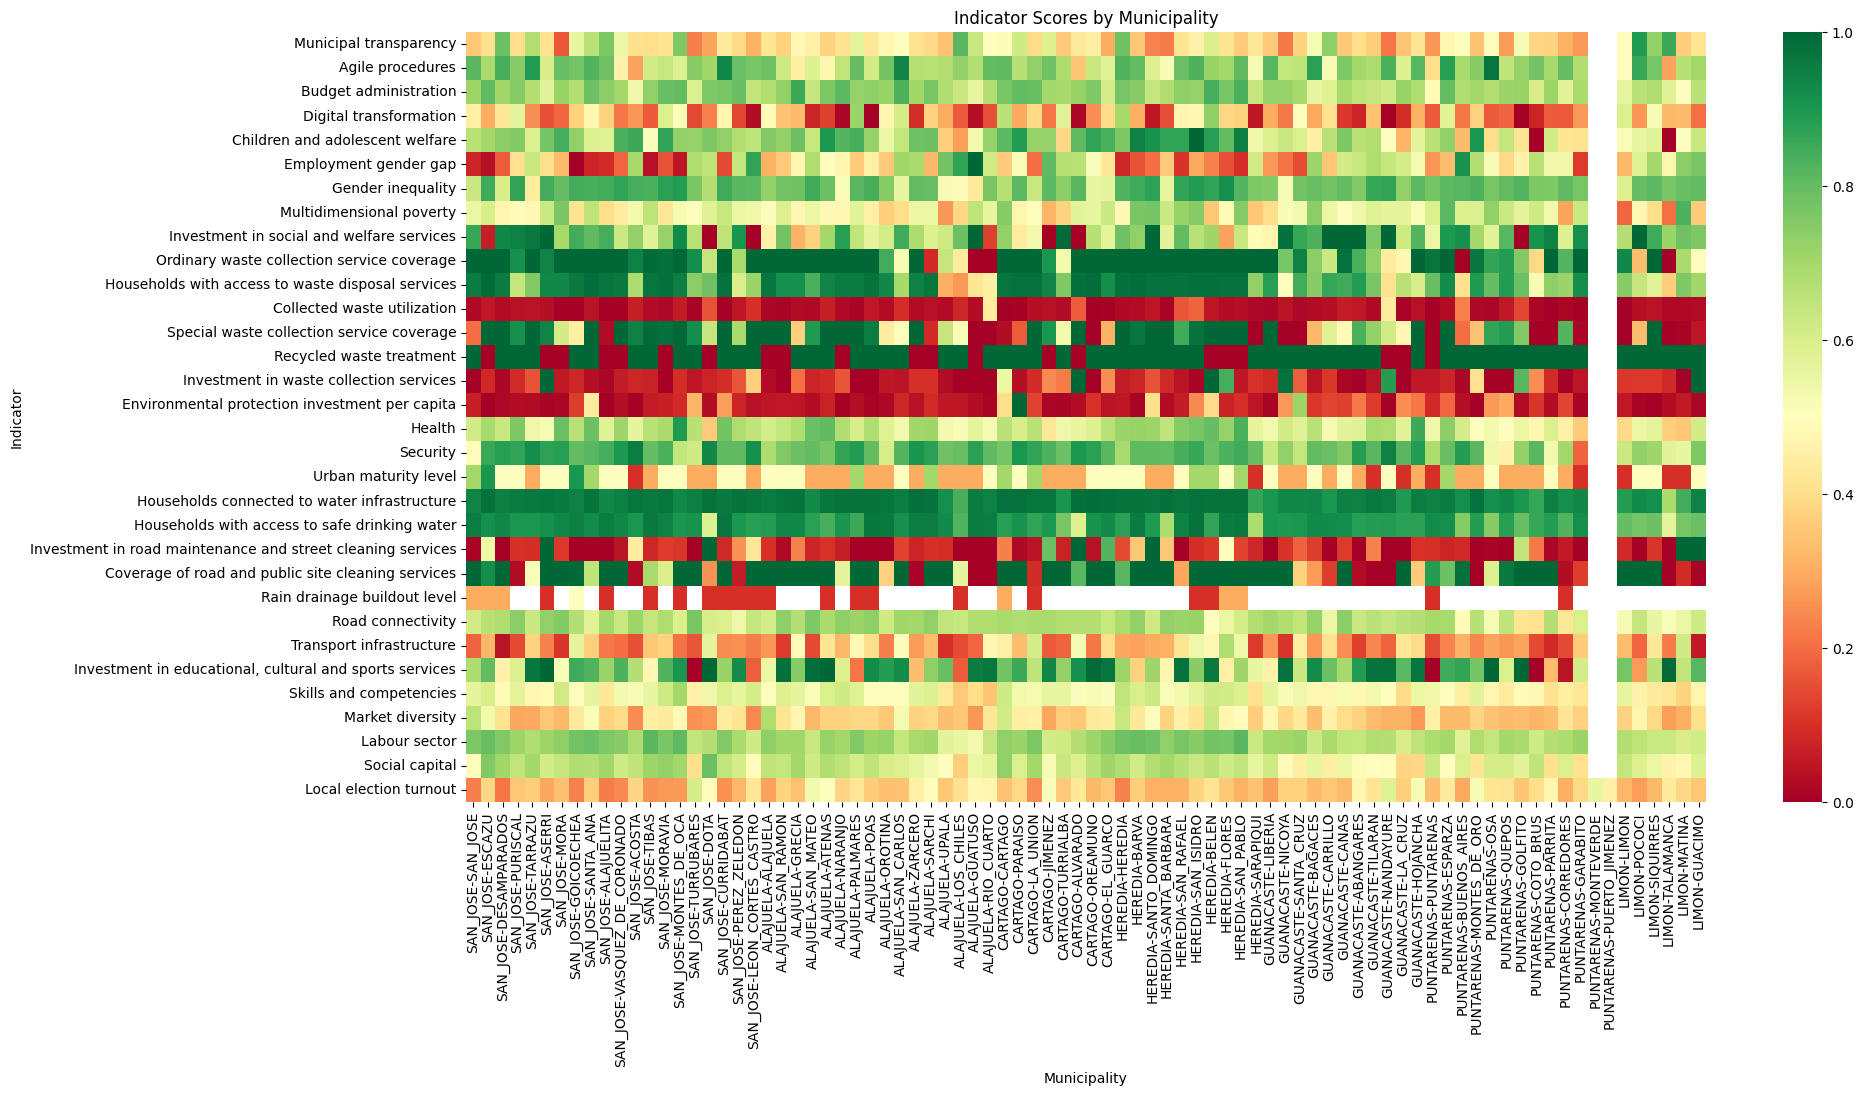

In [32]:
#

plt.figure(figsize=(20,10))
sns.heatmap(indicators_flipped, cmap='RdYlGn')

plt.title('Indicator Scores by Municipality')
plt.ylabel('Indicator')
plt.xlabel('Municipality')

# Show the plot
plt.show()

Proportion of topics in general and by province

In [36]:
data = pd.read_csv("C:/Users/carme/Dropbox/MIO/DOCS/Hertie/Thesis/Hertie-Thesis/Python-Data/clean_data.csv")
#                   c:\Users\carme\Dropbox\MIO\DOCS\Hertie\Thesis\Elecciones_Municipales_2024\clean_data.csv

In [37]:
data[data['Votos'].isnull()]
#not sure where it began its existence but there is a values that we don't want
data = data.drop([62])
# copy the data
d1 = data.copy()
# keep the columns we want
d1 = d1[['Provincia','Municipalidad','Partido','Candidato','Ganador','Votos','Participacion','Abstencionismo']]
# add id to match the topics dis id
d1['doc_id'] = d1['Provincia'] + '-' + d1['Municipalidad'] + '-' + d1['Partido']

d1.head()

Provincia Municipalidad                               Partido  \
0  SAN_JOSE      SAN_JOSE  PARTIDO_REPUBLICANO_SOCIAL_CRISTIANO   
1  SAN_JOSE      SAN_JOSE               PARTIDO_JUNTOS_SAN_JOSE   
2  SAN_JOSE        ESCAZU                  PARTIDO_TERRA_ESCAZU   
3  SAN_JOSE        ESCAZU              PARTIDO_NUEVA_GENERACION   
4  SAN_JOSE        ESCAZU  PARTIDO_YUNTA_PROGRESISTA_ESCAZUCENA   

                     Candidato  Ganador    Votos  Participacion  \
0  CARLOS ALBERTO ARCE AGUILAR      0.0   1806.0         0.2303   
1    LUIS DIEGO MIRANDA MENDEZ      1.0  13026.0         0.2303   
2           MARIO ARCE GUILLEN      0.0   2212.0         0.3846   
3  ORLANDO ESTEBAN UMANA UMANA      1.0   5983.0         0.3846   
4  JOSE PABLO CARTIN HERNANDEZ      0.0   1284.0         0.3846   

   Abstencionismo                                             doc_id  
0          0.7697  SAN_JOSE-SAN_JOSE-PARTIDO_REPUBLICANO_SOCIAL_C...  
1          0.7697          SAN_JOSE-SAN_JOSE-PARTIDO_JUNTOS_SAN_JOSE  
2          0.6154               SAN_JOSE-ESCAZU-PARTIDO_TERRA_ESCAZU  
3          0.6154           SAN_JOSE-ESCAZU-PARTIDO_NUEVA_GENERACION  
4          0.6154  SAN_JOSE-ESCAZU-PARTIDO_YUNTA_PROGRESISTA_ESCA...

In [38]:
data.shape

(565, 10)

In [39]:
int = pd.merge(d1, df, left_on='doc_id',right_index=True)

## Topics Visualization

In [40]:
topics_province = pd.melt((int.drop(columns=['Municipalidad','Partido','Candidato','Ganador','Votos','Participacion','Abstencionismo','doc_id'])), id_vars='Provincia',
                          var_name='Topic', value_name='Sum_Prop') 

topics_province = topics_province.groupby(['Provincia','Topic']).sum().reset_index()

topics_province['Topic'] = topics_province['Topic'].str.replace(r" \(.*\)", "", regex = True)

#shorten length of topics
topics_province['Short_Topic'] = topics_province['Topic'].apply(lambda x: x.split()[0] if isinstance(x, str) else x)

#topics_province['Short_Topic'] = topics_province['Topic'].apply(lambda x: (x[:14] + '...') if len(x) > 12 else x)

# topics_province.head(50)

In [41]:
fig = px.treemap(topics_province,
                 path=['Provincia','Short_Topic'],
                 values = 'Sum_Prop')
# layout and dimensions
fig.update_layout( height = 1200,
                  width = 1000)

#
fig.show()




## Correlation grid

In [42]:
indicators = pd.read_csv('C:/Users/carme/Dropbox/MIO/DOCS/Hertie/Thesis/Elecciones_Municipales_2024/Indicators_for_comparison/indicators_for_comparison_stand.csv')

In [43]:
# int = pd.merge(d1, df, left_on='doc_id',right_index=True)
int_2 = pd.merge(int, indicators, on=['Provincia','Municipalidad'], how='left')

In [44]:
#rename column that has the same name twice
int_2 = int_2.rename(columns={"Grado de Madurez Alcantarillado Pluvial 2023.1":"Rain drainage buildout level",
                                                        ' Cobertura del servicio  de recolección de residuos ordinario':'Ordinary waste collection service coverage',
                                                        ' Cobertura del servicio de recolección de residuos selectivo':'Special waste collection service coverage',
                                                        'Administración presupuestaria':'Budget administration',
                                                        'Aprovechamiento de residuos recolectados':'Collected waste utilization',
                                                        'Bienestar de Ninez y Adolescencia (2020)':'Children and adolescent welfare',
                                                        'Brecha de género en empleo': 'Employment gender gap', 
                                                        'Capital social': 'Social capital',
                                                        'Cobertura del servicio de aseo de vías y sitios públicos':'Coverage of road and public site cleaning services',
                                                        'Conectividad vial': 'Road connectivity', 
                                                        'Desiguadad de Genero (2020)': 'Gender inequality',
                                                        'Dinamismo de mercados': 'Market diversity',
                                                        'Grado de Madurez Urbanismo 2023': 'Urban maturity level',
                                                        'Habilidades y competencias': 'Skills and competencies',
                                                        'Hogares con acceso a agua por tubería': 'Households connected to water infrastructure',
                                                        'Hogares con acceso a agua potable': 'Households with access to safe drinking water',
                                                        'Hogares con acceso a eliminación de basura': 'Households with access to waste disposal services',
                                                        'Infraestructura de transporte': 'Transport infrastructure',
                                                        'Inversión en el servicio de aseo de vías y sitios públicos': 'Investment in road maintenance and street cleaning services',
                                                        'Inversión en el servicio de recolección de residuos': 'Investment in waste collection services',
                                                        'Inversión en servicios educativos, culturales y deportivos': 'Investment in educational, cultural and sports services',
                                                        'Inversión en servicios sociales y complementarios': 'Investment in social and welfare services',
                                                        'Inversión per cápita en protección del medio ambiente':'Environmental protection investment per capita',
                                                        # 'Madurez Alcantarillado Pluvial 20232':'',
                                                        'Participacion electoral municipal (2024)':'Local election turnout',
                                                        'Pobreza Multidimensional (2021)': 'Multidimensional poverty',
                                                        'Salud': 'Health_ind', 
                                                        'Sector laboral': 'Labour sector',
                                                        'Seguridad': 'Security_ind',
                                                        'Transformación digital': 'Digital transformation',
                                                        'Transparencia municipal': 'Municipal transparency',
                                                        'Tratamiento de residuos valorizables': 'Recycled waste treatment',
                                                        'Trámites ágiles':'Agile procedures',
                                                        #from here it's the topicses
                                                        'Transparency and Digital Government (Transparencia y gobierno digital)':'Transparency and Digital Government',
                                                        'Economic Boost (Crecimiento economico)': 'Economic Boost',
                                                        'Security (Seguridad)':'Security',
                                                        'Institutional Cooperation (Cooperacion Institucional)':'Institutional Cooperation',
                                                        'Vulnerable Populations (Poblaciones vulnerables)':'Vulnerable Populations',
                                                        'Environment Protection (Proteccion del medio ambiente)':'Environment Protection',
                                                        'Strategy and Planification (Estrategia y planificacion)':'Strategy and Planification',
                                                        'Education (Educacion)':'Education',
                                                        'Municipal Administration (Administracion municipal)':'Municipal Administration',
                                                        'Entrepreneurship (Emprendimiento)':'Entrepreneurship',
                                                        'Sustainability and climate change (Sostenibilidad y cambio climatico)':'Sustainability and climate change',
                                                        'Recreation (Recreacion)':'Recreation',
                                                        'Residue Management (Manejo de residuos)':'Residue Management',
                                                        'Youth Wellbeing (Bienestar Juvenil)':'Youth Wellbeing',
                                                        'Mobility Infrastructure (Infraestructura de movilidad)':'Mobility Infrastructure',
                                                        'Public Space Infrastructure (Infraestructura de espacios publicos)':'Public Space Infrastructure',
                                                        'Municipal Roads (Red vial cantonal)':'Municipal Roads',
                                                        'Sustainable Urbanism (Urbanismo sostenible)':'Sustainable Urbanism',
                                                        'Mobility and Transportation (Mobilidad ciudadana y transporte)':'Mobility and Transportation',
                                                        'Tourism (Turismo)':'Tourism',
                                                        'Community Engagement (Participacion ciudadana)':'Community Engagement',
                                                        'Refurbishment of public spaces (Reacondicionamiento de espacios publicos)':'Refurbishment of public spaces',
                                                        'Sustainable Water Management (Manejo sostenible del agua)':'Sustainable Water Management',
                                                        'Sports (Deporte)':'Sports', 
                                                        'Gender Equality (Equidad de genero)':'Gender Equality',
                                                        'Budget Administration (Administracion presupuestaria)':'Budget Administration',
                                                        'Youth Problems (Problemas en juventud)':'Youth Problems',
                                                        'Culture (Cultura)':'Culture',
                                                        'Agriculture and Livestock (Agropecuario)':'Agriculture and Livestock',
                                                        'Health (Salud)':'Health',
                                                        'Taxes (Impuestos)':'Taxes', 
                                                        'Emergencies (Emergencias)':'Emergencies',
                                                        'Environment (Medio ambiente)':'Environment', 
                                                        'Housing (Vivienda)':'Housing',
                                                        'Animal Welfare (Bienestar animal)':'Animal Welfare'
                                                        })

In [45]:
pairs_to_correlate = [
    ('Transparency and Digital Government', 'Digital transformation'),
    ('Transparency and Digital Government', 'Agile procedures'),
    ('Transparency and Digital Government', 'Municipal transparency'),
    
    ('Economic Boost', 'Labour sector'),
    ('Economic Boost', 'Market diversity'),
    ('Entrepreneurship', 'Labour sector'),
    ('Entrepreneurship', 'Market diversity'),

    ('Security', 'Security_ind'),

    ('Vulnerable Populations', 'Investment in social and welfare services'),
    ('Youth Wellbeing', 'Children and adolescent welfare'),
    ('Gender Equality', 'Investment in social and welfare services'),
    ('Gender Equality', 'Employment gender gap'),
    ('Youth Problems', 'Children and adolescent welfare'),

    ('Environment Protection', 'Environmental protection investment per capita'),
    ('Sustainability and climate change', 'Environmental protection investment per capita'),
    ('Environment', 'Environmental protection investment per capita'),

    ('Education', 'Investment in educational, cultural and sports services'),
    ('Education', 'Skills and competencies'),

    ('Recreation', 'Investment in educational, cultural and sports services'),
    ('Culture', 'Investment in educational, cultural and sports services'),
    ('Sports', 'Investment in educational, cultural and sports services'),

    ('Housing', 'Multidimensional poverty'),

    ('Residue Management', 'Collected waste utilization'),
    ('Residue Management', 'Ordinary waste collection service coverage'),
    ('Residue Management', 'Special waste collection service coverage'),
    ('Residue Management', 'Investment in waste collection services'),
    ('Residue Management', 'Recycled waste treatment'),

    ('Mobility Infrastructure', 'Road connectivity'),
    ('Public Space Infrastructure', 'Transport infrastructure'),
    ('Municipal Roads', 'Transport infrastructure'),
    ('Municipal Roads', 'Rain drainage buildout level'),
    ('Mobility and Transportation', 'Transport infrastructure'),

    ('Health', 'Health_ind'),

    ('Budget Administration', 'Budget administration'),

    ('Sustainable Urbanism', 'Urban maturity level'),

    ('Community Engagement', 'Local election turnout'),
    ('Community Engagement', 'Social capital'),

    ('Refurbishment of public spaces', 'Coverage of road and public site cleaning services'),

    ('Sustainable Water Management', 'Households with access to safe drinking water'),
    ('Sustainable Water Management', 'Households connected to water infrastructure')
]

In [51]:
# Calculate Spearman correlations for each pair and store results in a dictionary
spearman_correlations = {}
for col1, col2 in pairs_to_correlate:
    spearman_correlations[(col1, col2)] = int_2[col1].corr(int_2[col2], method='spearman')


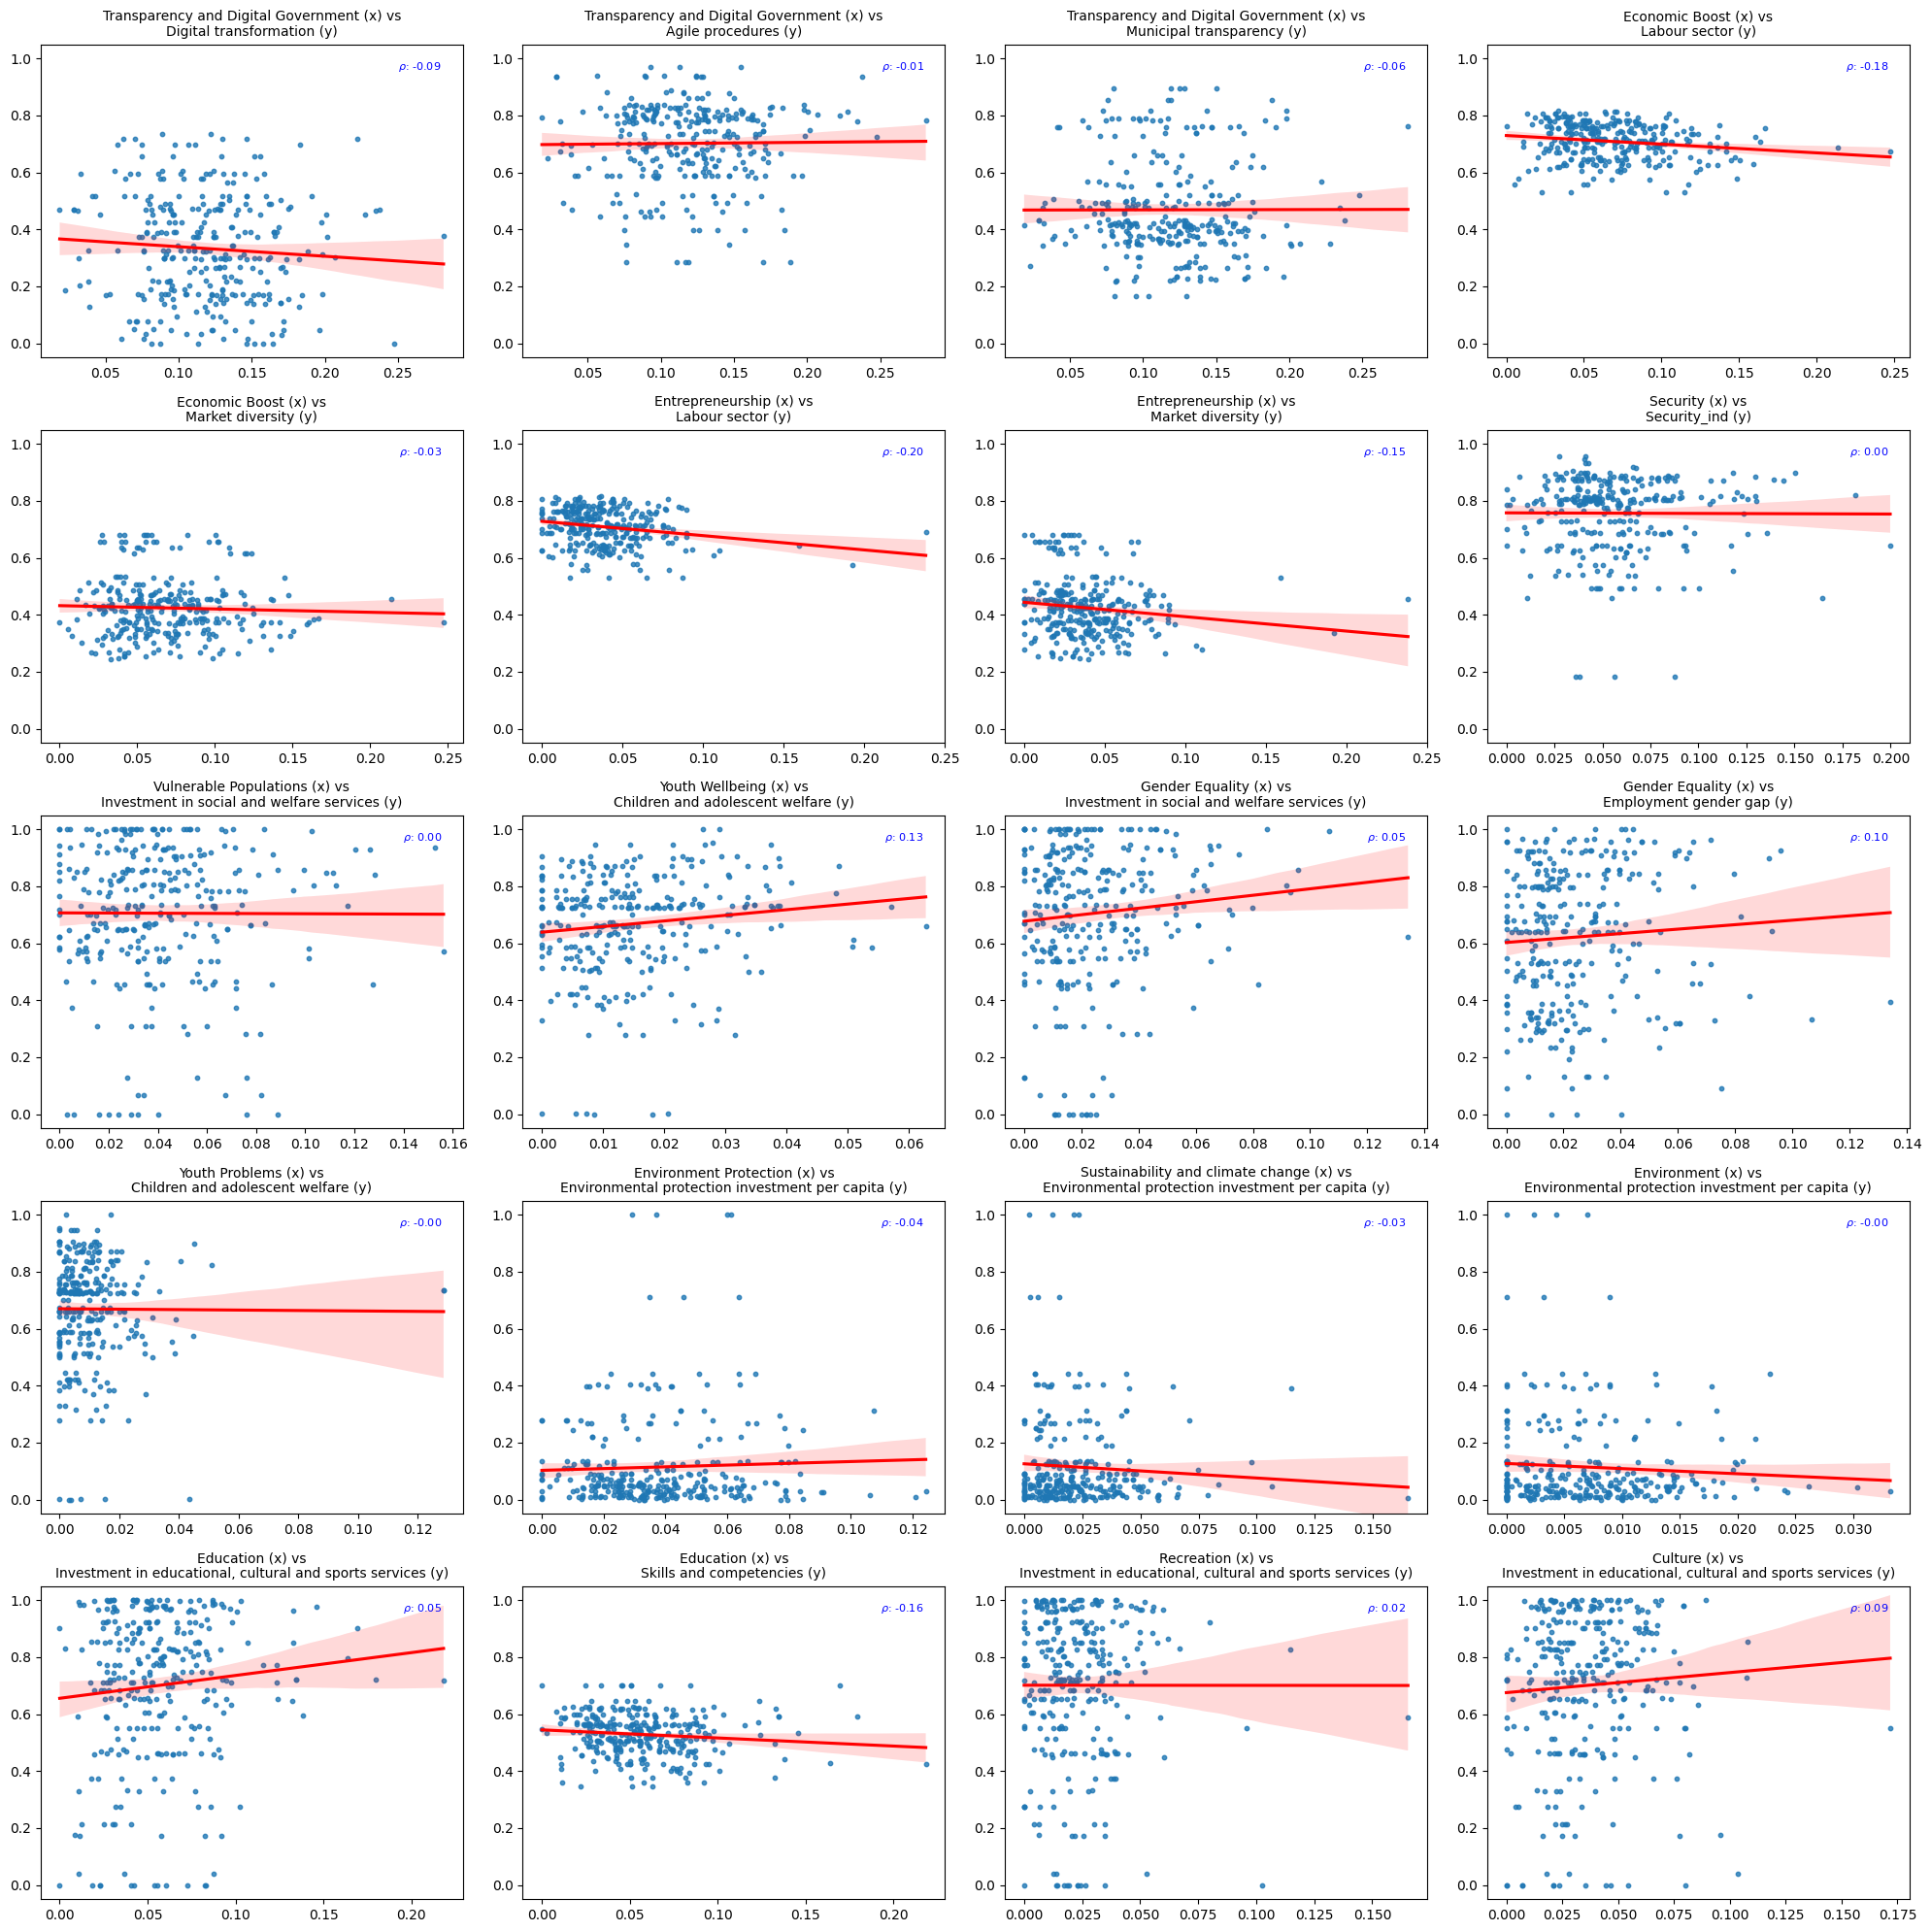

In [52]:
# Function to create plots for given pairs
def create_plots(pairs, nrows, ncols, figure_number):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy looping
    
    # Iterate through the list of pairs and the axes
    for idx, ((col1, col2), ax) in enumerate(zip(pairs, axes)):
        correlation = int_2[col1].corr(int_2[col2], method='spearman')  # Calculate Spearman correlation coefficient
        sns.regplot(x=col1, y=col2, data=int_2, ax=ax, scatter_kws={'s': 10}, line_kws={'color': 'red'})  # Scatter plot with trend line
        ax.set_title(f'{col1} (x) vs\n{col2} (y)', fontsize=10)  # Set title
        ax.text(0.95, 0.95, f'$\\rho$: {correlation:.2f}', verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes, color='blue', fontsize=8)  # Add correlation coefficient to top right
        #ax.set_xlim(0, 1)  # Set the limits for the x-axis
        ax.set_ylim(-0.05, 1.05)  # Set the limits for the y-axis
        # Set x and y labels to empty to hide them
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Turn off any unused axes
    for ax in axes[idx + 1:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Define the number of rows and columns for the subplot grid
n_rows = 5
n_cols = 4

# Assuming there are too many pairs, we split them into two figures
mid_point = len(pairs_to_correlate) // 2  # Find the mid point to split pairs
create_plots(pairs_to_correlate[:mid_point], n_rows, n_cols, figure_number=1)  # First half of pairs



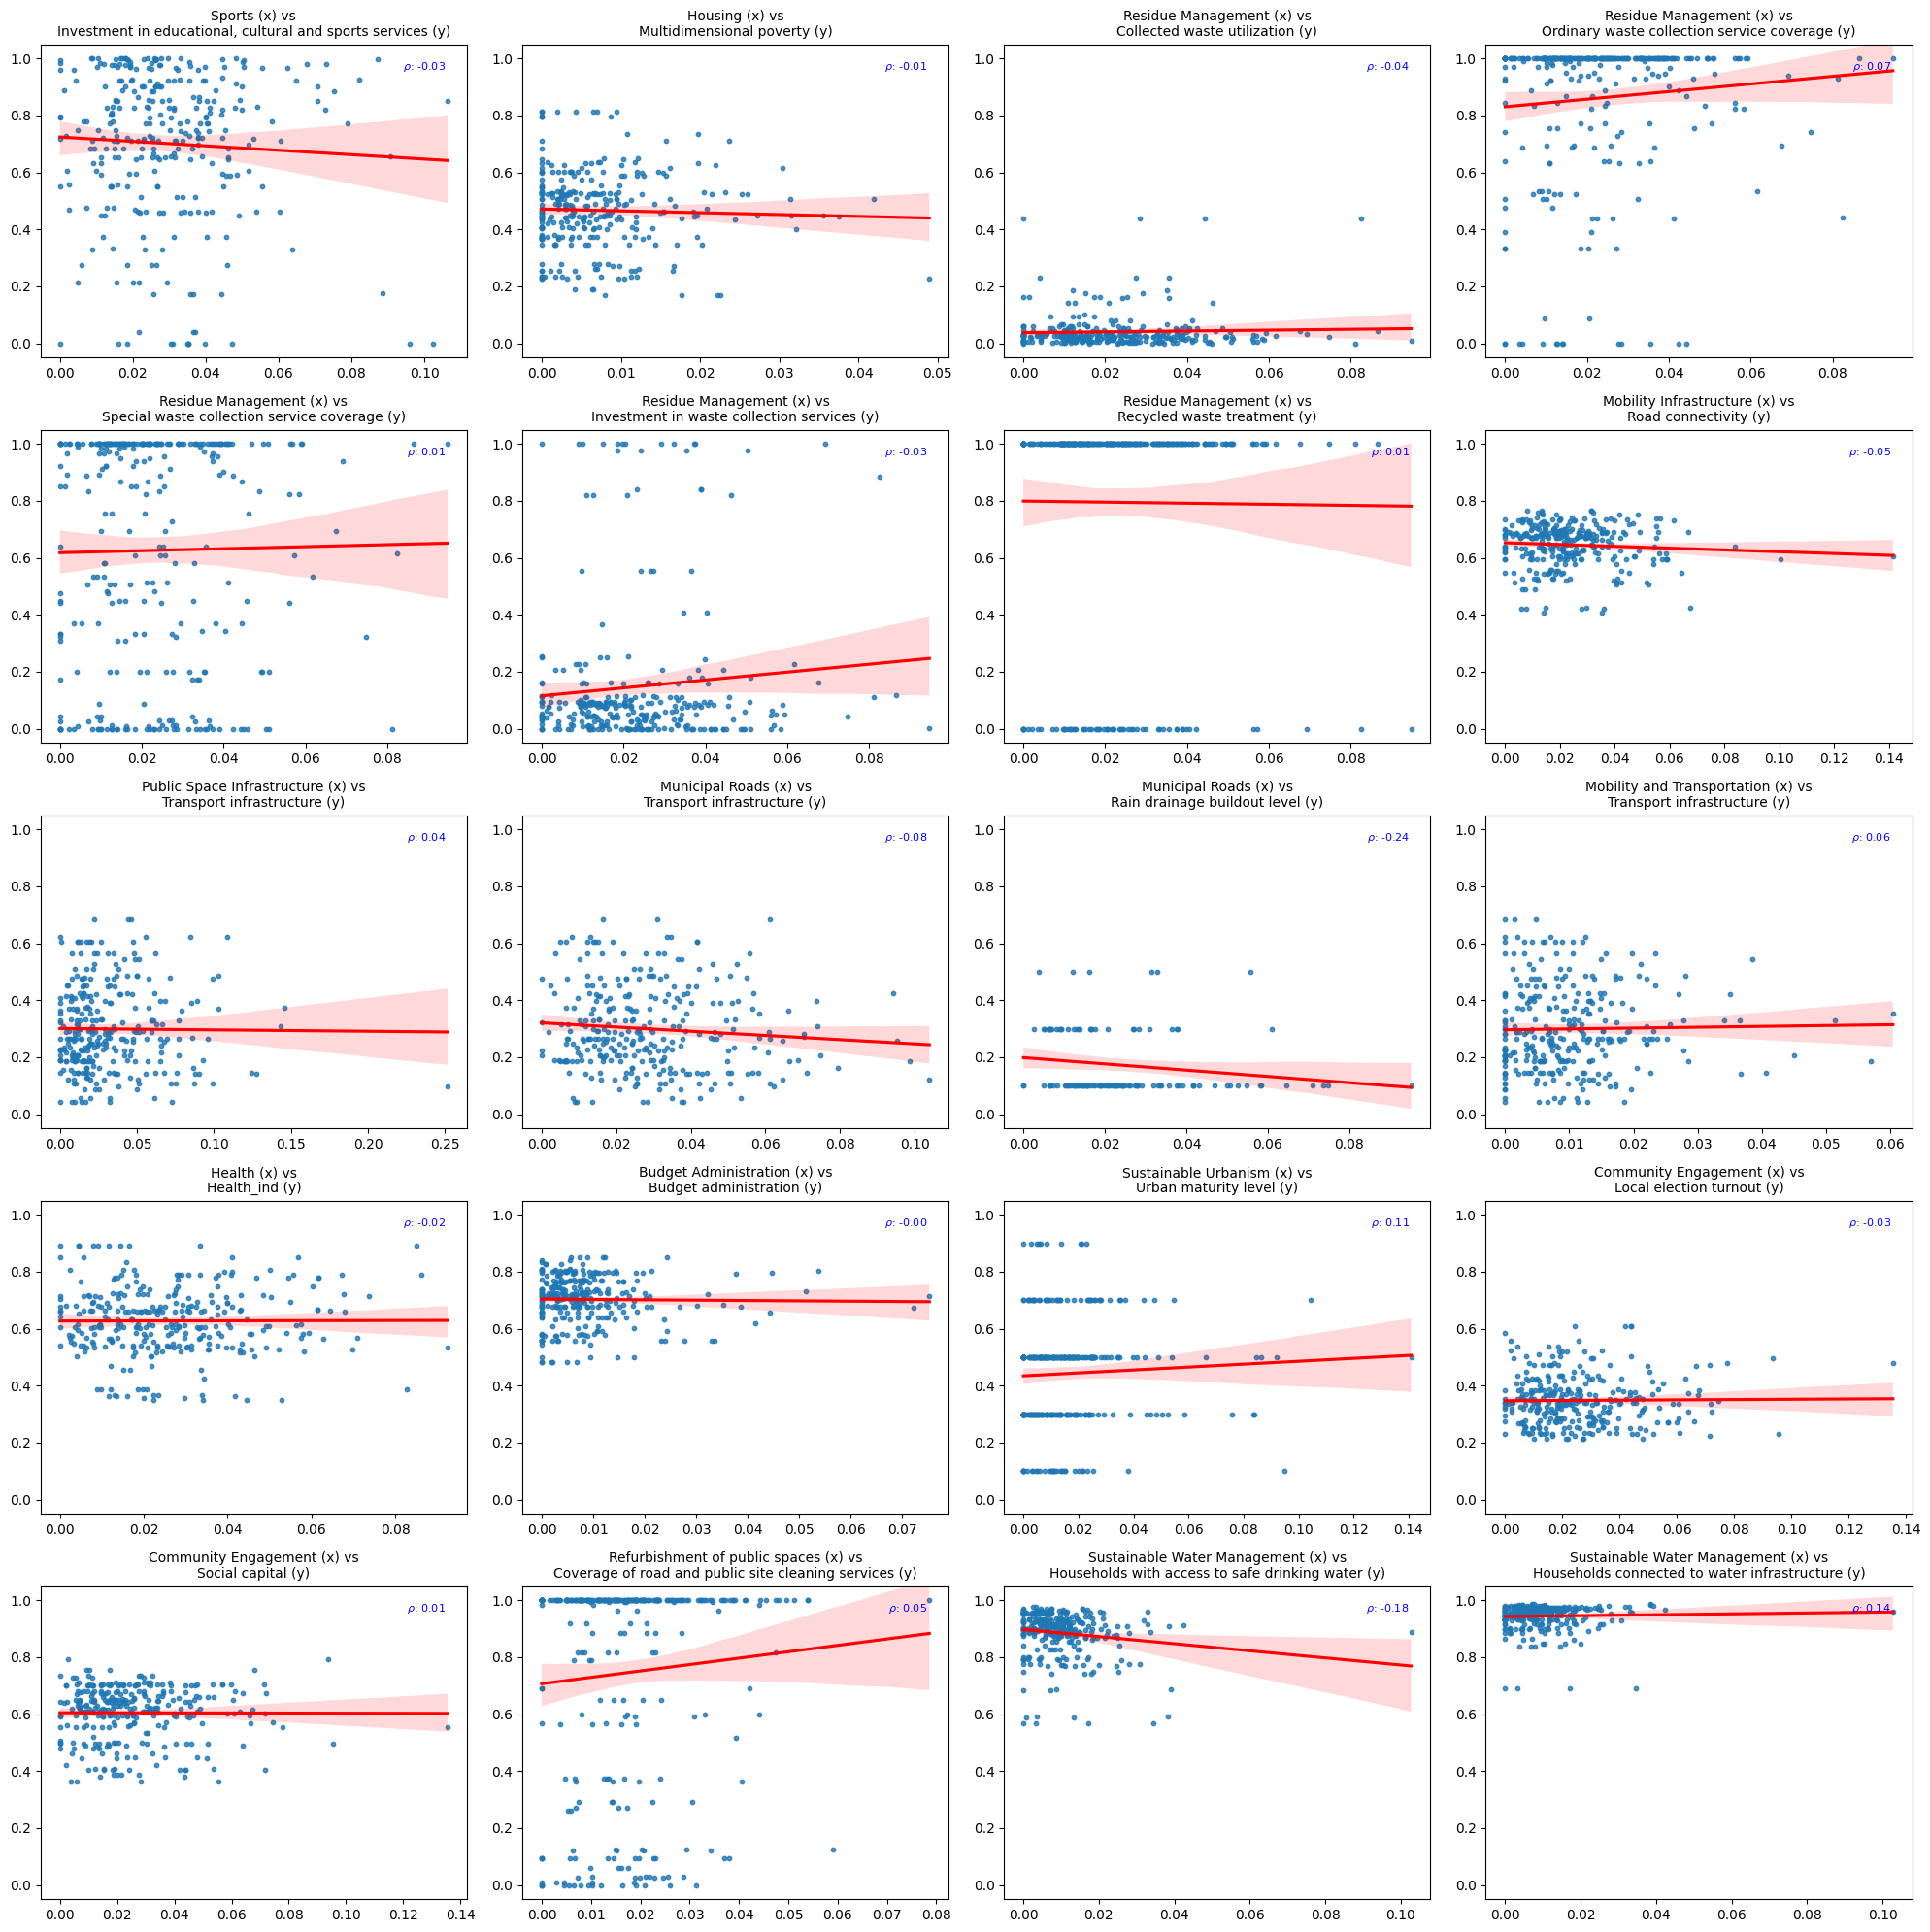

In [53]:
create_plots(pairs_to_correlate[mid_point:], n_rows, n_cols, figure_number=2)  # Second half of pairs

### Let's see if winners have a different behaviour

In [ ]:
int_ganadores = int_2.copy()

int_ganadores = int_ganadores.loc[int_ganadores['Ganador'] == 1]

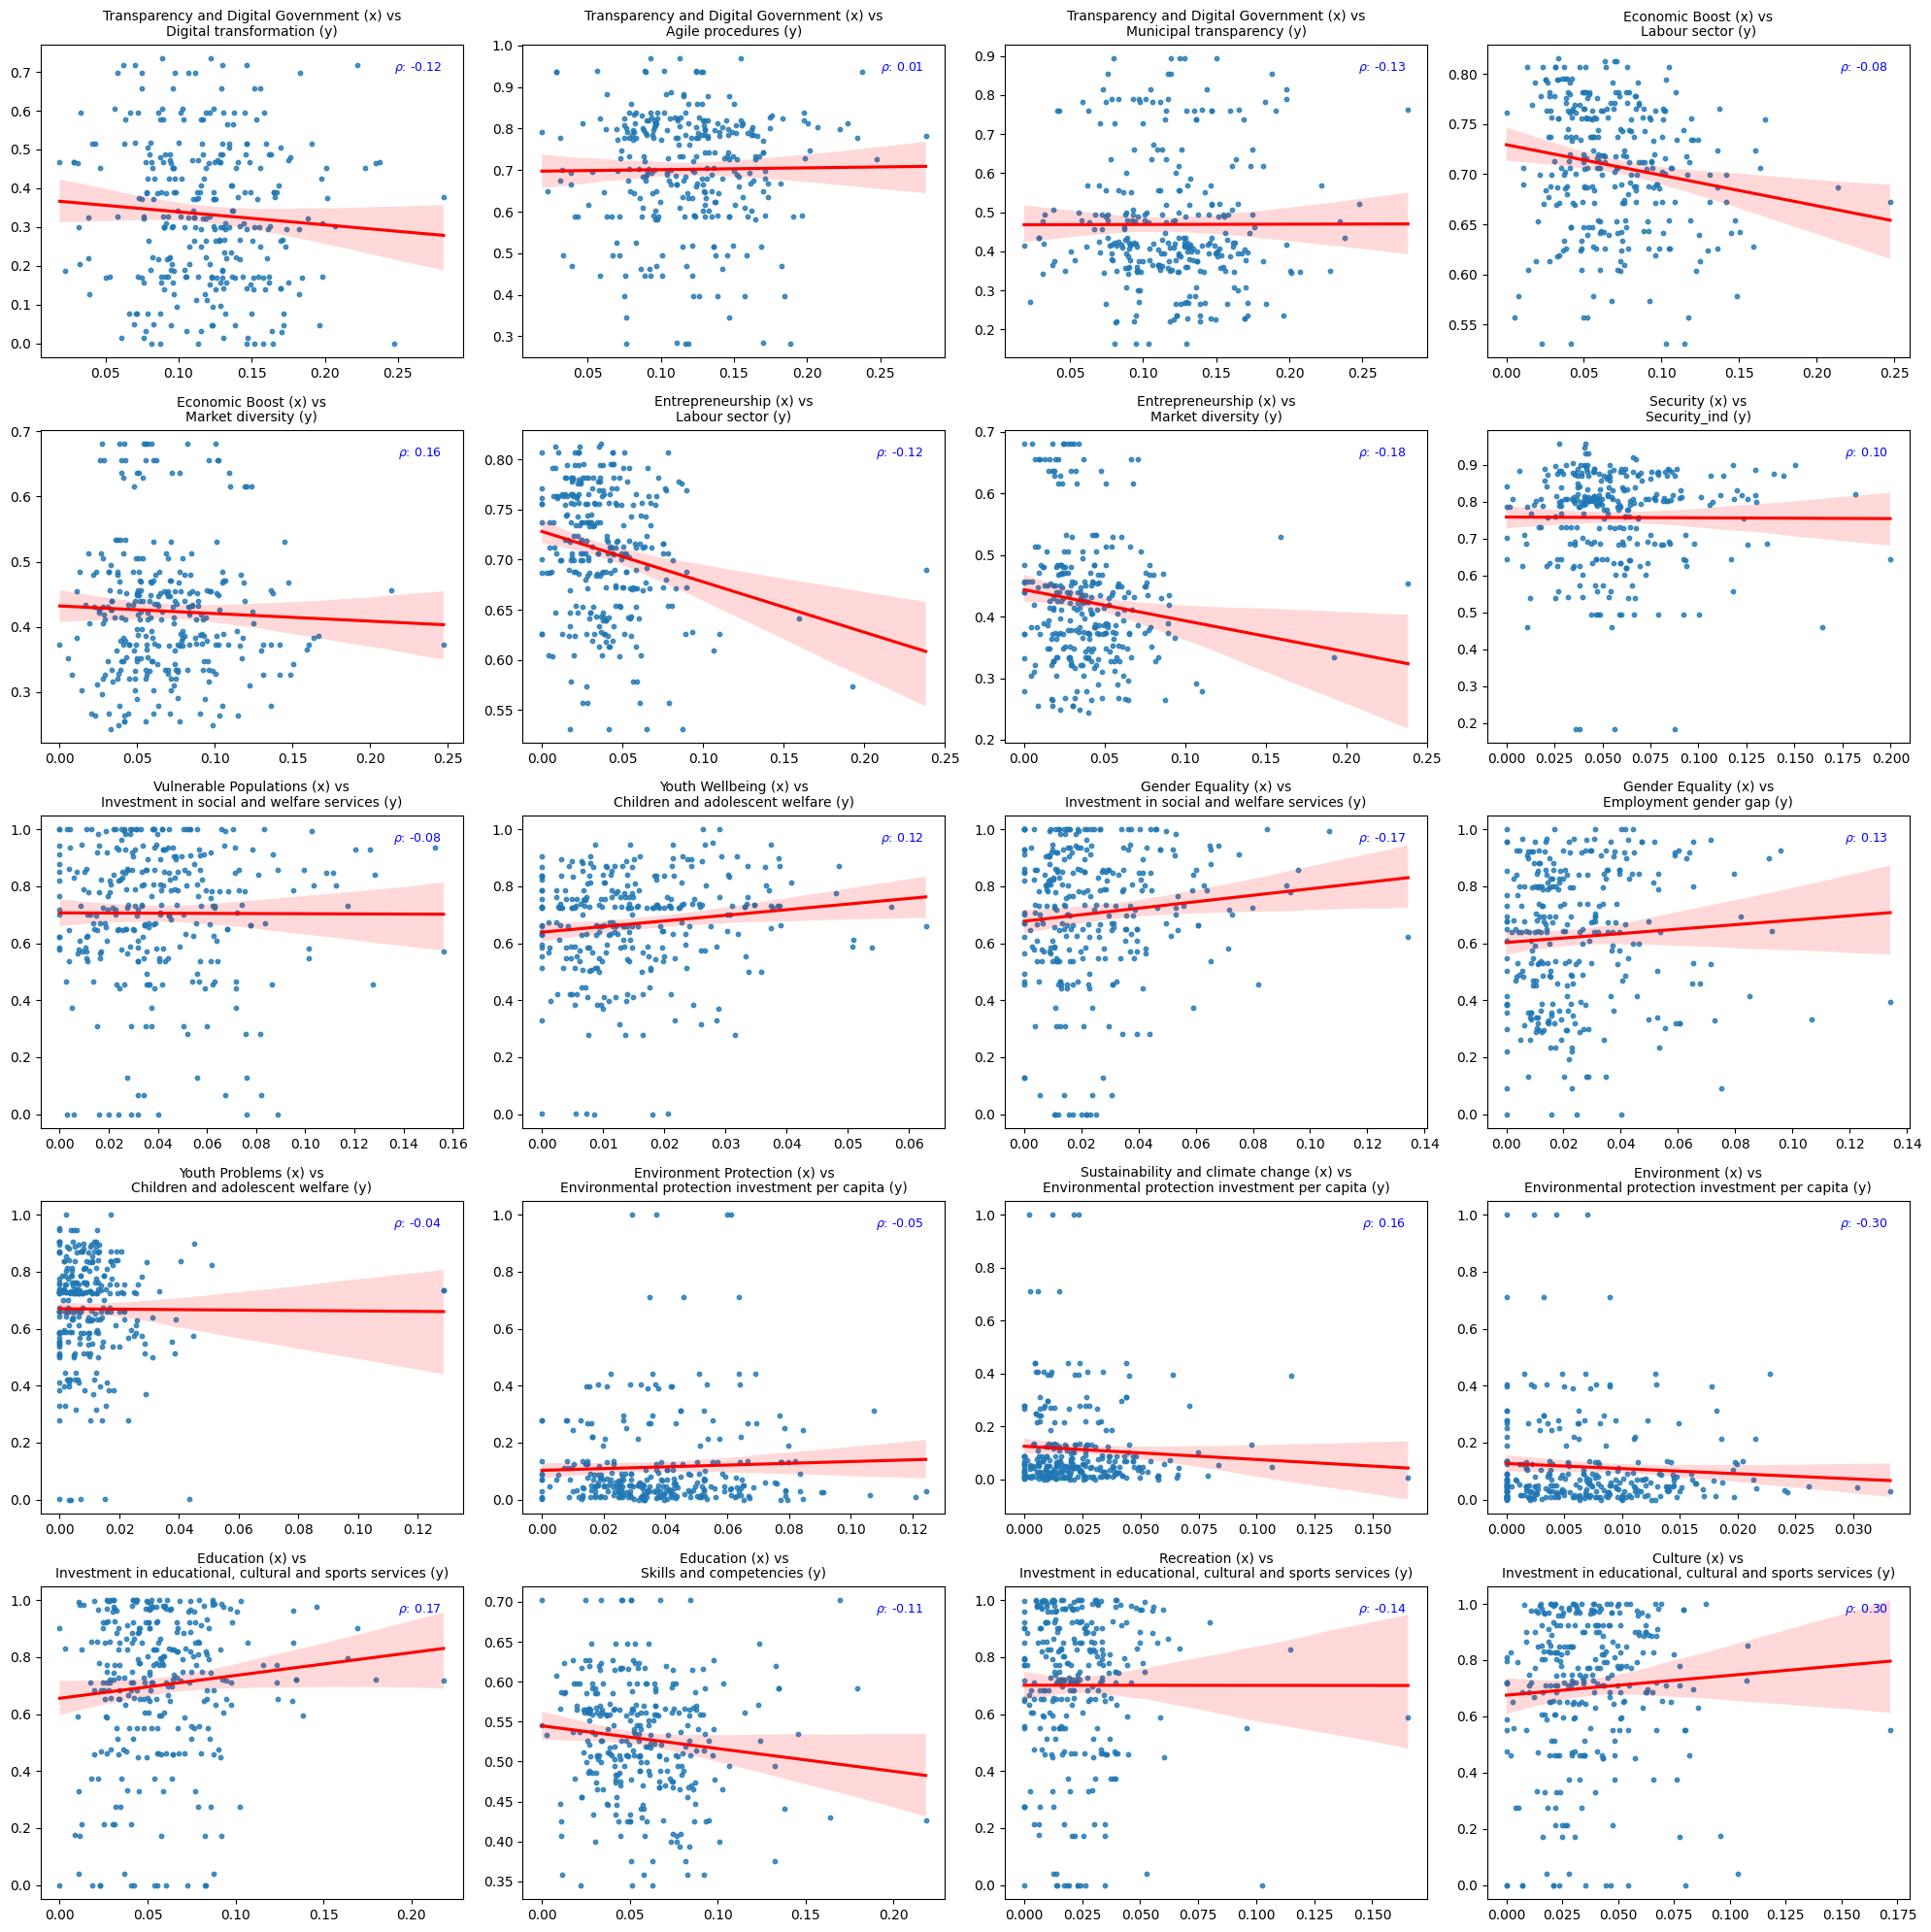

In [ ]:
# Function to create plots for given pairs
def create_plots(pairs, nrows, ncols, figure_number):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy looping
    
    # Iterate through the list of pairs and the axes
    for idx, ((col1, col2), ax) in enumerate(zip(pairs, axes)):
        correlation = int_ganadores[col1].corr(int_ganadores[col2], method='spearman')  # Calculate Spearman correlation coefficient
        sns.regplot(x=col1, y=col2, data=int_2, ax=ax, scatter_kws={'s': 10}, line_kws={'color': 'red'})  # Scatter plot with trend line
        ax.set_title(f'{col1} (x) vs\n{col2} (y)', fontsize=10)  # Set title
        ax.text(0.95, 0.95, f'$\\rho$: {correlation:.2f}', verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes, color='blue', fontsize=9)  # Add correlation coefficient to top right
        # Set x and y labels to empty to hide them
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Turn off any unused axes
    for ax in axes[idx + 1:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Define the number of rows and columns for the subplot grid
n_rows = 5
n_cols = 4

# Assuming there are too many pairs, we split them into two figures
mid_point = len(pairs_to_correlate) // 2  # Find the mid point to split pairs
create_plots(pairs_to_correlate[:mid_point], n_rows, n_cols, figure_number=1)  # First half of pairs

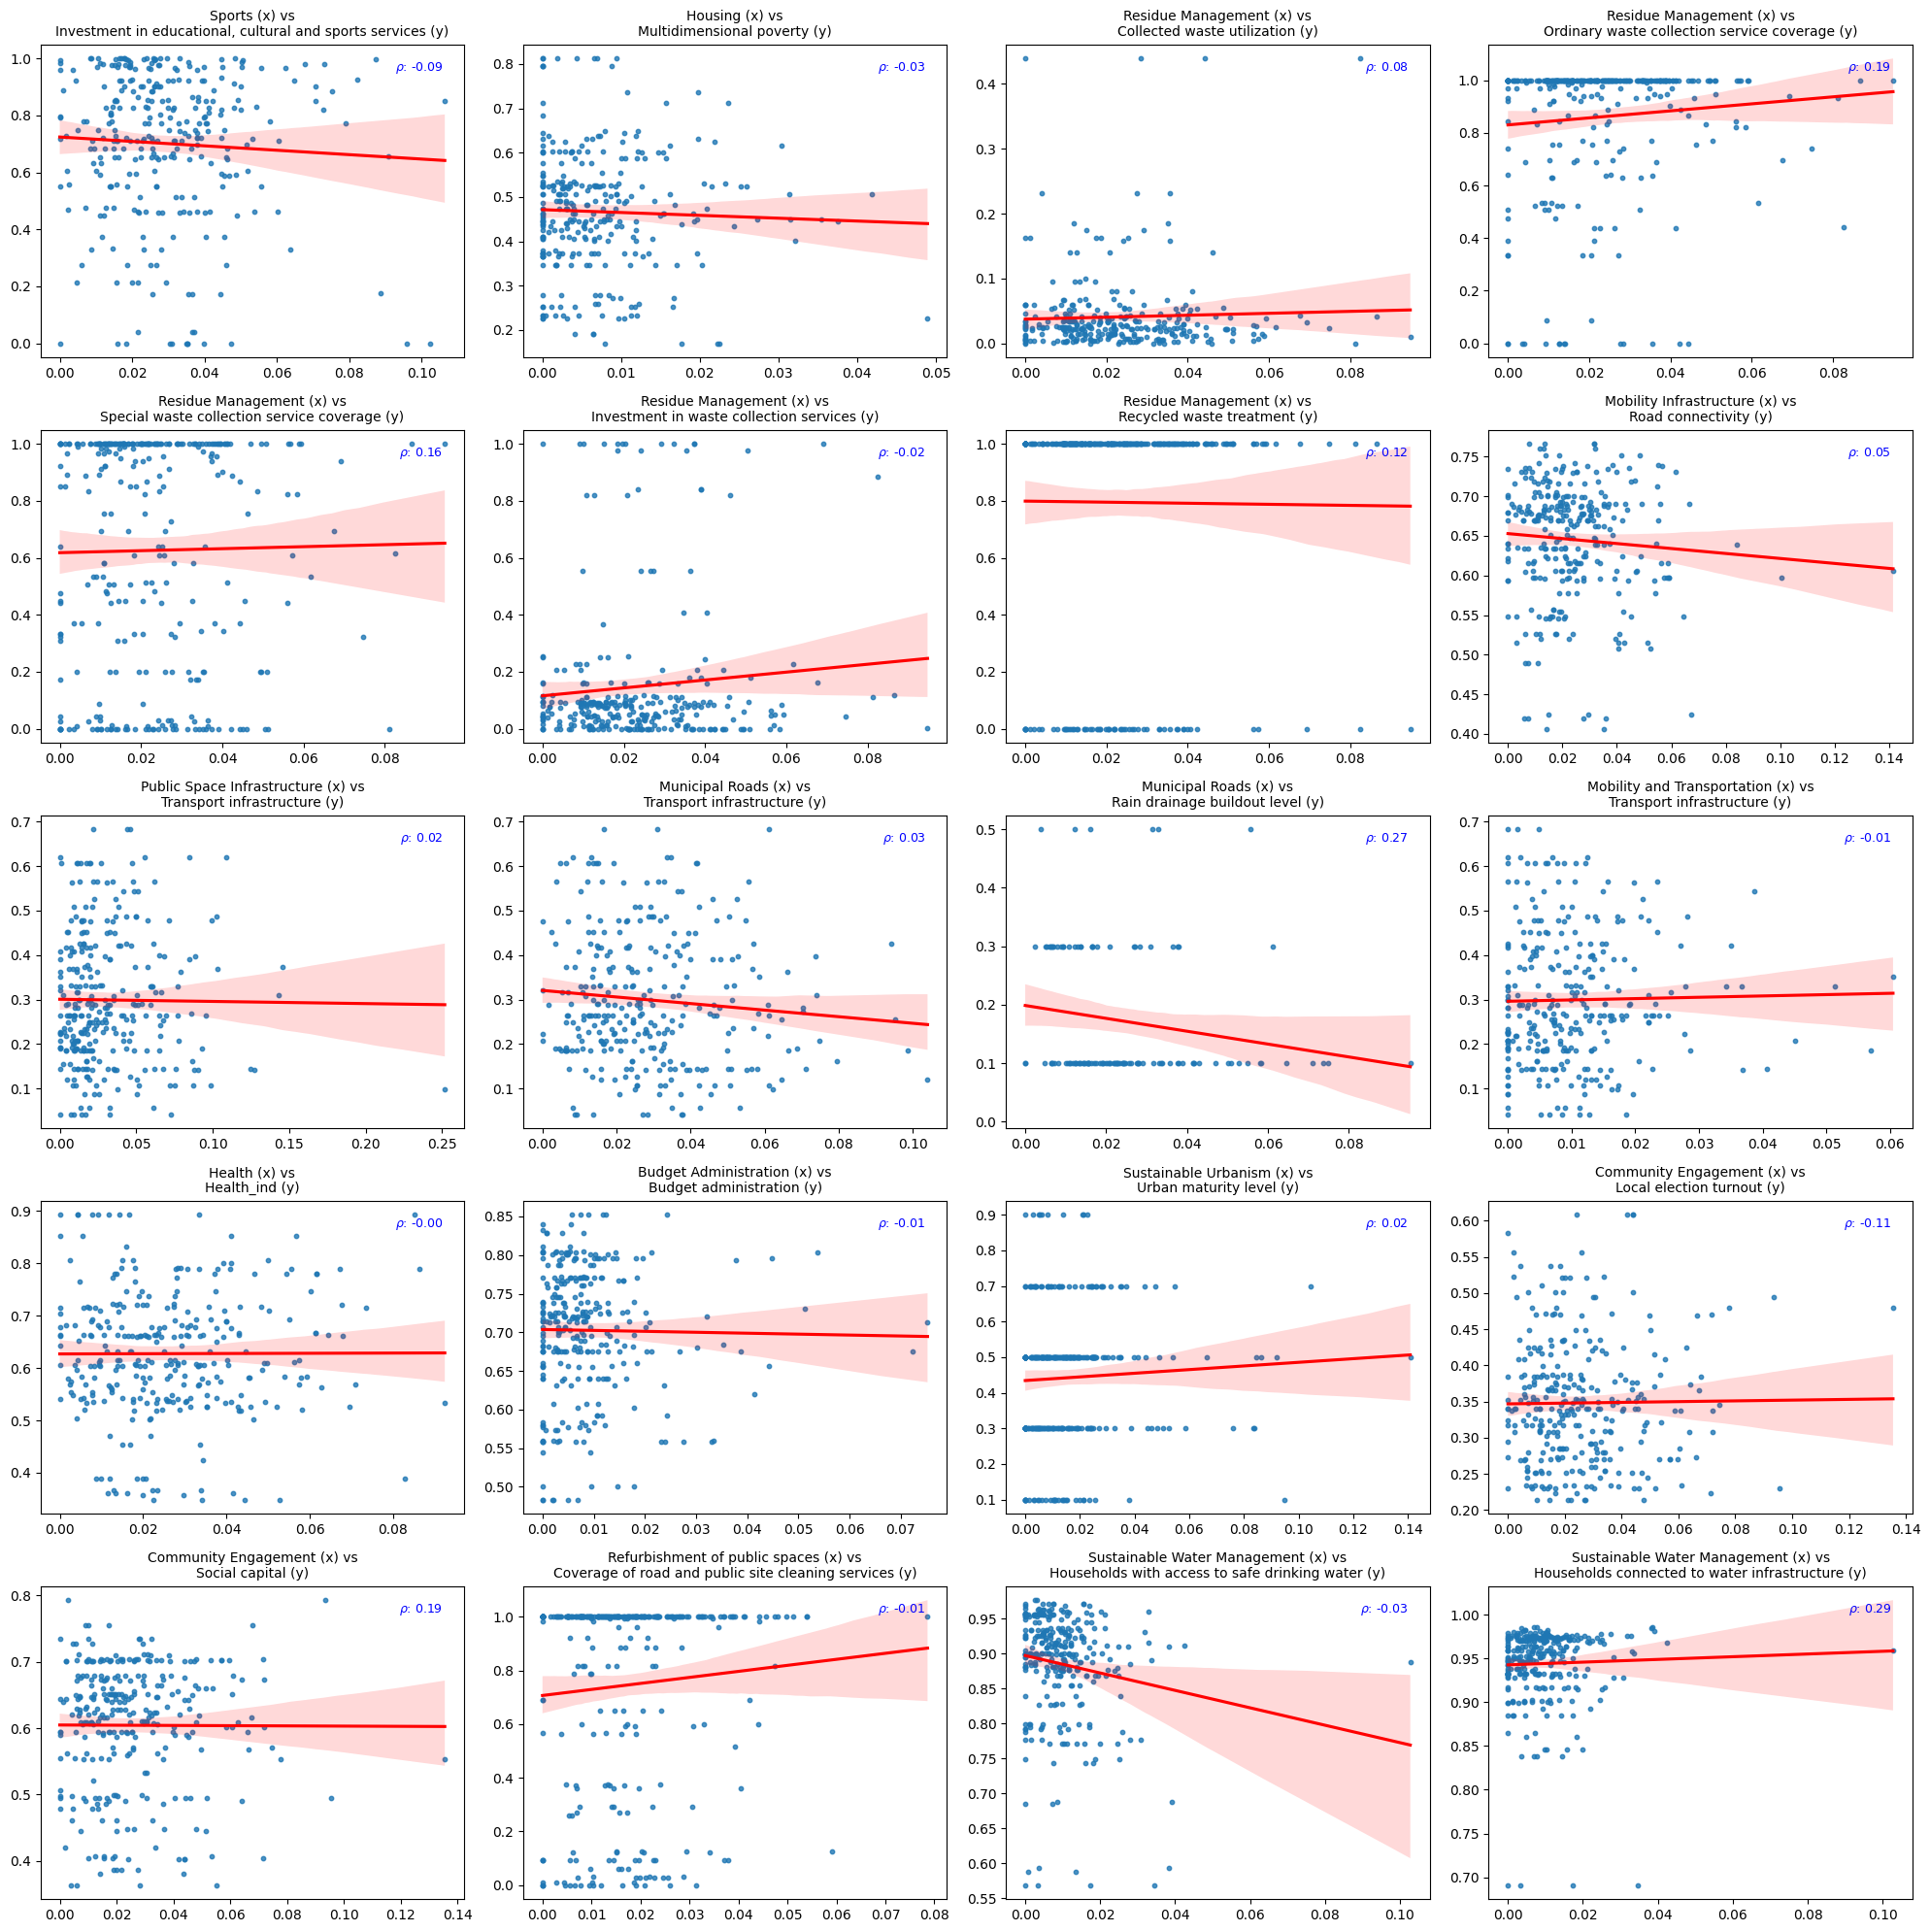

In [ ]:
create_plots(pairs_to_correlate[mid_point:], n_rows, n_cols, figure_number=2)  # Second half of pairs

In [ ]:
int_ganadores_grid = int_ganadores[['doc_id','Transparency and Digital Government', 'Economic Boost',
       'Security', 'Institutional Cooperation', 'Vulnerable Populations',
       'Environment Protection', 'Strategy and Planification',
       'Education', 'Municipal Administration', 'Entrepreneurship',
       'Sustainability and climate change', 'Recreation',
       'Residue Management', 'Youth Wellbeing', 'Mobility Infrastructure',
       'Public Space Infrastructure', 'Municipal Roads',
       'Sustainable Urbanism', 'Mobility and Transportation', 'Tourism',
       'Community Engagement', 'Refurbishment of public spaces',
       'Sustainable Water Management', 'Sports', 'Gender Equality',
       'Budget Administration', 'Youth Problems', 'Culture',
       'Agriculture and Livestock', 'Health', 'Taxes', 'Emergencies',
       'Environment', 'Housing', 'Animal Welfare']]

# set Municipalidad as the index
int_ganadores_grid.set_index('doc_id', inplace = True)
# transpose to compare if this one is better
int_ganadores_grid = int_ganadores_grid.transpose()
# getting topics in desired order
int_ganadores_grid = int_ganadores_grid.loc[['Transparency and Digital Government', 
                                             'Institutional Cooperation',
                                             'Strategy and Planification',
                                             'Municipal Administration',
                                             'Budget Administration',
                                             'Taxes',

                                             'Economic Boost',
                                             'Entrepreneurship',

                                             'Vulnerable Populations',
                                             'Youth Wellbeing',
                                             'Youth Problems',
                                             'Gender Equality',

                                             'Security', 

                                             'Health', 
                                              
                                             'Emergencies',

                                             'Community Engagement',

                                             'Tourism',

                                             'Agriculture and Livestock',

                                             'Residue Management',
                                              
                                             'Sustainable Water Management',
                                             'Mobility and Transportation',
                                             'Mobility Infrastructure',
                                             'Public Space Infrastructure', 
                                             'Municipal Roads',
                                             'Refurbishment of public spaces',

                                             'Animal Welfare',
                                             'Environment Protection',
                                             'Sustainability and climate change', 
                                             'Environment' ,

                                             'Housing', 
                                             'Sustainable Urbanism',
                                             
                                             'Education', 
                                             'Culture',
                                             'Sports', 
                                             'Recreation'
                                             ]]


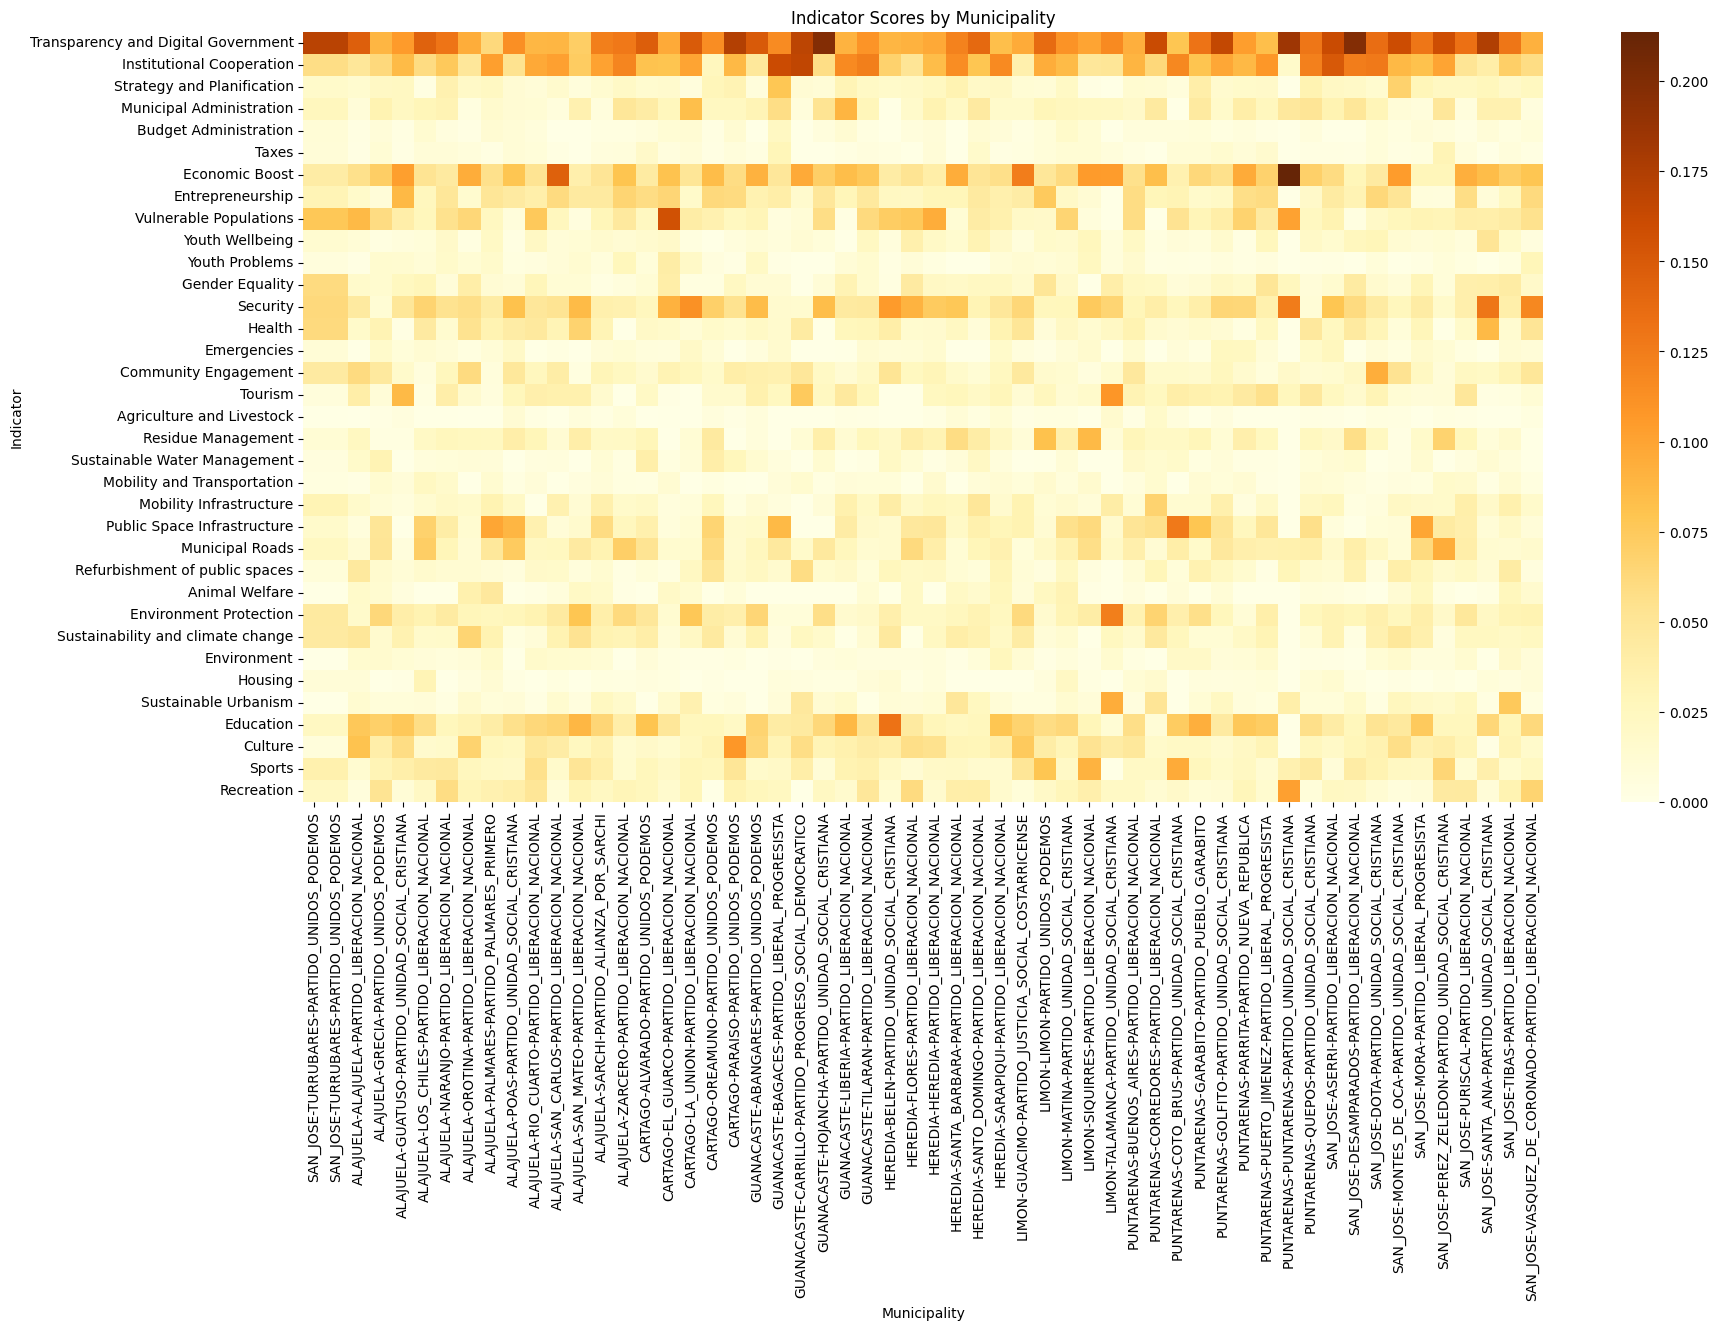

In [ ]:
#

plt.figure(figsize=(20,10))
sns.heatmap(int_ganadores_grid, cmap='YlOrBr')

plt.title('Indicator Scores by Municipality')
plt.ylabel('Indicator')
plt.xlabel('Municipality')

# Show the plot
plt.show()

In [34]:
int_2.to_csv('C:/Users/carme/Dropbox/MIO/DOCS/Hertie/Thesis/Hertie-Thesis/topics_and_indicators.csv', encoding='utf-8')

NameError: name 'int_2' is not defined